Dakar-Natal

In [1]:
import subprocess
import os
import datetime
from dateutil.rrule import rrule, WEEKLY, MO
import h5py
import numpy as np
import pandas as pd
from datetime import datetime
import numpy as np
import pygrib
import scipy 
from scipy import stats
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation

Dakar:  lat: 14.716677
        lon: -17.467686
            
Natal:  lat:  -5.812757
        lon: -35.255127
#source env/bin/activate        
#python3 -m dabry real -17.47 14.72 -35.26 -5.81 202201010000 23.0 1000

La direction du vent est généralement exprimée en degrés, avec des valeurs allant de 0 à 360 degrés. Voici la correspondance des valeurs de direction du vent en degrés avec les points cardinaux :

    0 degré (ou 360 degrés) : Nord
    90 degrés : Est
    180 degrés : Sud
    270 degrés : Ouest

Les valeurs intermédiaires entre ces points cardinaux représentent les directions intermédiaires. Par exemple, 45 degrés représente la direction nord-est, 135 degrés représente la direction sud-est, 225 degrés représente la direction sud-ouest, et ainsi de suite.

Cependant, il est important de noter que certaines conventions peuvent varier en fonction du domaine d'application. 

## Download of data 

In [2]:
python_path = '/usr/local/insa/anaconda/bin/python3'
dabry_path = '/home/duplanti/Documents/projet 4A bis/dabry'

os.environ['DABRYPATH'] = dabry_path

### Dakar - Natal (2018-2022, 1000mb)

In [ ]:

start_date = datetime(2018, 1, 1)
end_date = datetime(2023, 1, 1) #exclu

dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022

dates_str = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines


args0 = ['real', '-17.47', '14.72', '-35.26', '-5.81','23.0', '1000'] #liste des arguments du module SANS la date


In [ ]:
for date_str in dates_str:  # lance le module 52 fois pour les dates, coord et alt donnes
    args=args0.copy()
    args.insert(5, date_str) 
    subprocess.run([python_path, '-m', 'dabry'] + args)

# General functions

In [3]:
def get_wind_data(names,alt): #lit une liste des noms des fichiers grib et return dictionnaires avec les U/V comp a une date precise du grib
    #name='202201030000', alt = int 
    docgrib=[]
    for i in range(len(names)):
        docgrib.append(pygrib.open("/home/duplanti/Documents/projet 4A bis/dabry/data/cds/0.5/"+str(alt)+"/"+names[i]))
    
    
    #Création de deux dictionnaires qu'on retournera
    dicoU={}
    dicoV={}
    
    for i in range(len(names)):
        date_str=(names[i])[0:8]+'0000'
        docgrib_f=docgrib[i]
        grbU=docgrib_f.select(name='U component of wind')
        grbV=docgrib_f.select(name='V component of wind')
        dataU=grbU[0].data(lat1=-90,lat2=90,lon1=0,lon2=360) # retourne les valeurs et les matrices lon et lat
        dataV=grbV[0].data(lat1=-90,lat2=90,lon1=0,lon2=360)
        n1=np.shape(dataU[0])[0] #nb lignes (pareil pour U et V)
        n2=np.shape(dataU[0])[1] #nb colonnes
        for i in range(n1): 
            for j in range(n2): 
                lon=dataU[2][i,j]
                lat=dataU[1][i,j]
                dicoU[(lon,lat,date_str)]={}
                dicoV[(lon,lat,date_str)]={}
                dicoU[(lon,lat,date_str)]=dataU[0][i,j]
                dicoV[(lon,lat,date_str)]=dataV[0][i,j]
    return dicoU, dicoV
    

In [4]:
def get_coord_opt(f): #f = fichier output, get_coord_opt rend une matrice avec les coord_opt
    length=len(f['0']['data'])
    coord_opt=np.zeros((length,3))
    for i in range(len(f['0']['data'])):
        coord_opt[i][0]=f['0']['data'][i][0]*180/np.pi
        coord_opt[i][0]=int(coord_opt[i][0]%360)
        coord_opt[i][1]=f['0']['data'][i][1]*180/np.pi
        coord_opt[i][2]=f['0']['ts'][i]
    return coord_opt #coord_opt colonne 0 = lon, col 1 = lat, col 2 = date en str

def get_time_opt(f):
    time_opt=datetime.fromtimestamp(f['0']['ts'][0])-datetime.fromtimestamp(f['0']['ts'][-1])
    time_opt=abs(time_opt.total_seconds()/3600)
    return time_opt 




In [5]:
def round_to_half(nb):
    return round(nb*2)/2

def get_comp_opt_u(dicoU,dicoV,coord_opt): #rend valeurs de u,v corresp a traj_opt a une date precise
    u_opt=np.zeros(np.shape(coord_opt)[0])
    v_opt=np.zeros(np.shape(coord_opt)[0])
    i=0
    while i<np.shape(coord_opt)[0]:
        lon_min=round_to_half(coord_opt[i][0])
        lon_max=round_to_half(coord_opt[i][0])+0.5
        lat_min=round_to_half(coord_opt[i][1])
        lat_max=round_to_half(coord_opt[i][1])+0.5
        date=(datetime.fromtimestamp(coord_opt[i][2])).strftime('%Y%m%d0000')
        #if (coord_opt[i][2]==list(dicoU.keys())[i][2]) #on test si la date est ok 
        u_opt[i]=(dicoU[(lon_min,lat_min,date)]+dicoU[(lon_min,lat_max,date)]+dicoU[(lon_max,lat_min,date)]+dicoU[(lon_max,lat_max,date)])/4
        v_opt[i]=(dicoV[(lon_min,lat_min,date)]+dicoV[(lon_min,lat_max,date)]+dicoV[(lon_max,lat_min,date)]+dicoV[(lon_max,lat_max,date)])/4
        i+=1
    return u_opt,v_opt

In [6]:
def get_data_traj_opt(dates_str): #returns valeurs de u, v et temps de traj opt aux dates corresp a dates_str (ici : lundis 2022)
    u_v_time_opt={}
    for date_str in dates_str:#ici: loop sur les lundis de 2022 
            #on lit le fichier output corresp a chaque date
        try:
            f=h5py.File("/home/duplanti/Documents/projet 4A bis/dabry/output/zermelo_17W_15N_35W_6S_"+date_str[0:8]+"_00/trajectories.h5",'r')
            #on lit les fichiers cds data corresp a chaque date
            coord_opt=get_coord_opt(f) #on recup coord de traj et la date en str
            
            dates_traj_str=[]
            for i in range(len(coord_opt)):
                dates_traj_str.append((datetime.fromtimestamp(coord_opt[i,2])).strftime('%Y%m%d0000'))
            dates_traj_str=list(set(dates_traj_str))
            names=[date_traj[0:8]+'.grb2' for date_traj in dates_traj_str]
            #on recupere les dict avec toutes les valeurs U,V et coord de traj opt
            dicoU,dicoV=get_wind_data(names,1000)
            #on recupere les valeurs de U,V corresp a traj_opt
            u_v_time_opt[date_str]=[get_comp_opt_u(dicoU,dicoV,coord_opt),get_time_opt(f)]
        except OSError as e:
            print("File not found:", e)
    return u_v_time_opt

In [7]:
#calcul de la vitesse du vent pour 1 jour 

def get_windspeed_1day(u, v):
    vitesse_vent = []
    for i in range(len(u)):
        somme_carres = u[i] ** 2 + v[i] ** 2
        vitesse = math.sqrt(somme_carres)
        vitesse_vent.append(vitesse)
    return vitesse_vent

In [8]:
def get_avg_windspeed_1day(vitesse) :
    moy=0
    for i in range(len(vitesse)) :
        moy+= vitesse[i]
    moy=moy/len(vitesse)
    return moy

In [9]:
#dico avec u,v temp opt et dates
def get_windspeed_days (dico):
    res= [] 
    for i in dico.keys() :
        a=get_windspeed_1day(dico[""+i][0][0], dico[""+i][0][1])
        moy=get_avg_windspeed_1day(a)
        res=np.append(res,moy)
    return res

In [10]:
def get_winddir_1day(u, v):
    direction_degrees = np.degrees(np.arctan2(v, u))
    direction_degrees = (direction_degrees + 360) % 360
    return direction_degrees

In [11]:
def get_avg_winddir_1day(dire) :
    sin_sum = np.mean(np.sin(np.radians(dire)))
    cos_sum = np.mean(np.cos(np.radians(dire)))
    return (np.degrees(np.arctan2(sin_sum, cos_sum)) + 360) % 360

In [12]:
def get_winddir_days (dico):
    res=[] #tableau des jours
    for i in dico.keys() :
        a=get_winddir_1day(dico[""+i][0][0], dico[""+i][0][1])
        moy=get_avg_winddir_1day(a)
        res=np.append(res,moy)
    return res

In [13]:
def period_avg_speed(vect,nb_jours) :
    moy=0
    for i in range(len(vect)) :
        moy+= vect[i]  
    moy=moy/nb_jours
    return moy

In [14]:
def period_avg_dir(vect) :
    sin_sum = np.mean(np.sin(np.radians(vect)))
    return (np.degrees(np.arctan2(sin_sum, cos_sum)) + 360) % 360


In [15]:
def get_periods(dico,nb_periodes): #dico de u, v et temps de trajet opt
    #nb_periodes meilleures 
    sorted_x_best= dict(sorted(dico.items(), key=lambda x: x[1][1]))
    sorted_x_best=dict(list(sorted_x_best.items())[:nb_periodes])
    #nb_periodes pires
    sorted_x_worst= dict(reversed(sorted(dico.items(), key=lambda x: x[1][1])))
    sorted_x_worst=dict(list(sorted_x_worst.items())[:nb_periodes])
    return sorted_x_best,sorted_x_worst

In [16]:
def get_wind_cond(year,u_v_time_opt,nb_periodes):
    year_str=str(year)
    data_best,data_worst=get_periods(u_v_time_opt,nb_periodes)
    #get wind conditions over a year
    windspeed_year=get_windspeed_days(u_v_time_opt)
    winddir_year=get_winddir_days(u_v_time_opt)
    #get x% best wind conditions
    windspeed_best=get_windspeed_days(data_best)
    winddir_best=get_winddir_days(data_best)
    #get x% worst wind conditions
    windspeed_worst=get_windspeed_days(data_worst)
    winddir_worst=get_winddir_days(data_worst)
    return windspeed_year,winddir_year,windspeed_best,winddir_best,windspeed_worst,winddir_worst

In [17]:
def get_avg_wind_cond(windspeed_year,winddir_year,windspeed_best,winddir_best,windspeed_worst,winddir_worst):
    weeks=len(windspeed_year)
    nb_periodes=len(windspeed_best)
    return period_avg_speed(windspeed_year,weeks),period_avg_dir(winddir_year),period_avg_speed(windspeed_best,nb_periodes),period_avg_dir(winddir_best),period_avg_speed(windspeed_worst,nb_periodes),period_avg_dir(winddir_worst)


In [18]:
def get_traj_time(u_v_time_opt,nb_periodes):
    sorted_x_best,sorted_x_worst=get_periods(u_v_time_opt,nb_periodes)
    traj_time_year= [value[1] for value in u_v_time_opt.values()]
    traj_time_best=[value[1] for value in sorted_x_best.values()]
    traj_time_worst=[value[1] for value in sorted_x_worst.values()]
    return traj_time_year,traj_time_best,traj_time_worst

In [19]:
def get_avg_traj_time(traj_time_year,traj_time_best,traj_time_worst):
    return sum(traj_time_year)/len(traj_time_year),sum(traj_time_best)/len(traj_time_best),sum(traj_time_worst)/len(traj_time_worst)


In [20]:
def get_the_best_worst(u_v_time_opt):
    the_worst_data = max(u_v_time_opt.items(), key=lambda x: x[1][-1])
    the_best_data = min(u_v_time_opt.items(), key=lambda x: x[1][-1])
    return the_best_data,the_worst_data

In [21]:
def get_date_time(u_v_time_opt): #returns a dict with key=date in MMDD, value=list [avg traj windspeed, avg traj winddir, traj time]
    u_v_time_new={k[4:6]+'/'+k[6:8]:v for k,v in u_v_time_opt.items()}
    u_v_time_new={k:v for k,v in sorted(u_v_time_new.items(),key=lambda item:datetime.strptime(item[0],"%m/%d"))} #att, year  1900 par defaut
    u_v_time_new={k:[get_avg_windspeed_1day(get_windspeed_1day(v[0][0],v[0][1])),get_avg_winddir_1day(get_winddir_1day(v[0][0],v[0][1])),v[1]] for k, v in u_v_time_new.items()}
    return u_v_time_new


# Extracting data of optimal trajectories for each year

## 2022

In [22]:
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 1, 1) #exclu

dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022

dates_str_2022 = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines


In [23]:
u_v_time_opt_2022_base=get_data_traj_opt(dates_str_2022)
u_v_time_opt_2022_base

{'202201030000': [(array([-5.5231781 , -5.5231781 , -4.1703949 , -4.1703949 , -3.17137146,
          -3.25608826, -2.77000427, -2.77000427, -2.39353943, -3.90159607,
          -3.65769958, -3.65769958, -3.44309998, -4.31443787, -4.00682068,
          -4.00682068, -3.80638123, -3.87644958, -3.26829529, -3.26829529,
          -2.46434021, -3.23631287, -2.60618591, -2.60618591, -1.7172699 ,
          -2.61888123, -1.68870544, -1.68870544, -1.20579529, -1.20579529,
          -1.63816833, -2.60081482, -3.3044281 , -3.3044281 , -4.50071716,
          -4.50071716, -5.59788513, -5.59788513, -6.04710388, -6.04710388,
          -5.30931091, -5.30931091, -6.89793396, -6.89793396, -5.65354919,
          -5.65354919, -4.31297302, -2.58860779, -2.4306488 , -2.4306488 ,
          -2.4306488 , -2.4450531 , -2.4450531 , -2.94041443, -2.94041443,
          -3.40769958, -3.40769958, -4.12864685, -4.12864685, -5.1415863 ,
          -5.1415863 , -5.1415863 , -5.09544373, -5.09544373, -8.38012695,
         

##  2021

In [24]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2022, 1, 1) #exclu
dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022
dates_str_2021 = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines


In [25]:
u_v_time_opt_2021_base=get_data_traj_opt(dates_str_2021)
u_v_time_opt_2021_base


{'202101040000': [(array([-2.62988281, -2.62988281, -2.52758789, -2.52758789, -2.03466797,
          -2.03466797, -3.22143555, -3.22143555, -3.21704102, -3.21704102,
          -4.43994141, -4.43994141, -4.23974609, -4.23974609, -4.50976562,
          -4.50976562, -4.31616211, -4.31616211, -4.26660156, -4.26660156,
          -3.88818359, -3.88818359, -4.15771484, -4.15771484, -4.3515625 ,
          -4.3515625 , -5.31689453, -5.31689453, -5.2355957 , -5.2355957 ,
          -4.83544922, -5.40429688, -4.8125    , -4.8125    , -4.421875  ,
          -4.90771484, -4.70458984, -4.70458984, -4.15576172, -4.50683594,
          -4.04272461, -4.04272461, -3.72753906, -3.72753906, -3.43530273,
          -4.11108398, -4.4597168 , -4.4597168 , -4.97949219, -4.97949219,
          -5.37548828, -5.53930664, -5.81152344, -5.81152344, -5.95239258,
          -5.95239258, -6.10864258, -6.38110352, -6.38110352, -6.57446289,
          -6.57446289, -6.81958008, -6.73583984, -6.96630859, -5.67985535,
         

## 2020

In [26]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2021, 1, 1) #exclu
dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022
dates_str_2020 = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines


In [27]:
u_v_time_opt_2020_base=get_data_traj_opt(dates_str_2020)
u_v_time_opt_2020_base


{'202001060000': [(array([-4.96070862, -4.96070862, -4.79615784, -4.79615784, -4.07374573,
          -4.07374573, -4.63990784, -4.08180237, -4.08180237, -3.70606995,
          -5.16993713, -4.76783752, -4.35426331, -4.35426331, -4.73683167,
          -4.52589417, -4.52589417, -4.48390198, -4.56861877, -4.44825745,
          -4.33375549, -4.33375549, -3.80714417, -3.80714417, -3.5796051 ,
          -3.36940002, -3.68043518, -3.82398987, -3.82398987, -3.74610901,
          -4.26954651, -4.26954651, -4.60377502, -4.60377502, -3.72657776,
          -3.73707581, -3.73707581, -2.75440979, -2.75440979, -0.44117737,
           0.87400818,  0.87400818,  0.84886169,  0.84886169, -0.06251526,
          -0.18092346, -0.74708557, -0.74708557, -1.70729065, -1.70729065,
          -1.66676331, -1.66676331, -2.18873596, -2.18873596, -2.97071838,
          -1.83815002, -2.3440094 , -2.3440094 , -2.78834534, -3.48121643,
          -3.96095276, -3.96095276, -4.38209534, -5.04566956, -5.68678284,
         

## 2019

In [28]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2020, 1, 1) #exclu

dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO)) #on prend tous les lundis de 2022

dates_str_2019 = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines
 


In [29]:
u_v_time_opt_2019_base=get_data_traj_opt(dates_str_2019)
u_v_time_opt_2019_base


{'201901070000': [(array([-3.93696594, -3.93696594, -2.27827454, -2.27827454, -2.27827454,
          -2.195755  , -2.03608704, -2.49775696, -2.49775696, -2.63496399,
          -2.71943665, -3.14204407, -3.14204407, -3.15205383, -3.40034485,
          -3.55854797, -3.55854797, -3.4276886 , -3.84614563, -3.80073547,
          -3.80073547, -3.48652649, -3.76631165, -3.50068665, -3.50068665,
          -3.0473175 , -3.21357727, -3.21357727, -2.9108429 , -2.9108429 ,
          -3.20503235, -3.20503235, -3.02217102, -3.02217102, -3.727005  ,
          -3.80000305, -3.80000305, -3.90058899, -3.90058899, -4.72163391,
          -4.72163391, -4.40596008, -4.40596008, -4.78413391, -4.78413391,
          -4.93305969, -4.93305969, -5.17451477, -5.37934875, -5.32417297,
          -5.32417297, -4.65888977, -5.2389679 , -4.49043274, -4.49043274,
          -4.14277649, -4.14277649, -3.97529602, -4.86714172, -4.86714172,
          -4.48188782, -4.48188782, -3.93525696, -3.93525696, -4.9156189 ,
         

## 2018

In [30]:
start_date = datetime(2018, 1, 1)
end_date = datetime(2019, 1, 1) #exclu

dates = list(rrule(WEEKLY, dtstart=start_date, until=end_date, byweekday=MO))

dates_str_2018 = [date.strftime('%Y%m%d0000') for date in dates] #on prend 00h00, 52 elem pour 52 semaines
#print(dates_str)
 


In [31]:
u_v_time_opt_2018_base=get_data_traj_opt(dates_str_2018)
u_v_time_opt_2018_base


{'201801010000': [(array([-5.30627441, -5.30627441, -4.35778809, -4.35778809, -3.53991699,
          -4.23303223, -3.78161621, -3.78161621, -3.26452637, -3.99255371,
          -3.56213379, -3.56213379, -4.34143066, -4.08459473, -4.08459473,
          -3.7142334 , -4.64538574, -4.26428223, -4.26428223, -4.59997559,
          -4.59997559, -4.22277832, -4.22277832, -4.46374512, -4.46374512,
          -4.21789551, -4.67419434, -4.26086426, -4.26086426, -3.8717041 ,
          -4.37072754, -4.12219238, -4.12219238, -4.17956543, -4.17956543,
          -4.04284668, -4.04284668, -3.7623291 , -3.7623291 , -3.74743652,
          -3.74743652, -3.75256348, -4.35681152, -4.35681152, -4.82385254,
          -3.70056152, -3.93688965, -3.93688965, -4.41516113, -4.41516113,
          -4.20935059, -4.20935059, -4.20935059, -4.30773926, -4.30773926,
          -4.35949707, -4.6661377 , -4.68249512, -4.68249512, -4.85852051,
          -4.85852051, -5.23034668, -5.23034668, -5.64147949, -3.15681458,
         

# Comparison of data over 5 years (2018-2022)

## Primary analysis : detecting outliers

In [136]:

traj_time_2018=get_traj_time(u_v_time_opt_2018_base,13)[0]
traj_time_2019=get_traj_time(u_v_time_opt_2019_base,13)[0]
traj_time_2020=get_traj_time(u_v_time_opt_2020_base,13)[0]
traj_time_2021=get_traj_time(u_v_time_opt_2021_base,13)[0]
traj_time_2022=get_traj_time(u_v_time_opt_2022_base,13)[0]


In [137]:
u_v_time_opt_2018 = u_v_time_opt_2018_base
u_v_time_opt_2019 = u_v_time_opt_2019_base
u_v_time_opt_2020 = u_v_time_opt_2020_base
u_v_time_opt_2021 =u_v_time_opt_2021_base
u_v_time_opt_2022 = u_v_time_opt_2022_base


In [138]:
traj_time_5y=[traj_time_2018,traj_time_2019,traj_time_2020,traj_time_2021,traj_time_2022]
years=[2018,2019,2020,2021,2022]

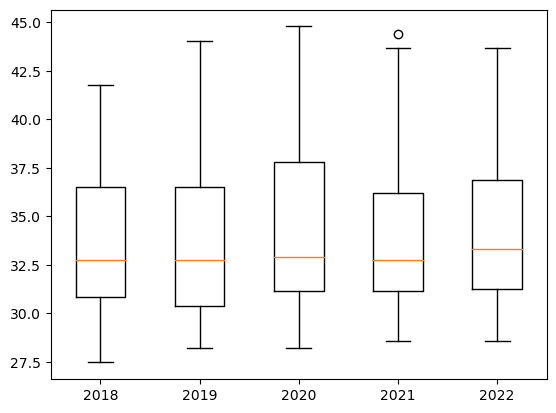

In [139]:
plt.boxplot(traj_time_5y,labels=years);

<font color = "purple"> On observe seulement un outlier pour l'année 2021. On le garde car peut nous apporter les infos sur les conditions défavorables

### Extracting data of shortest and longest trajectory times 

In [140]:
data_best_2018,data_worst_2018=get_periods(u_v_time_opt_2018,13) # 25% of shortest and longest trajectory times

In [141]:
windspeed_2018,winddir_2018,windspeed_best_2018,winddir_best_2018,windspeed_worst_2018,winddir_worst_2018=get_wind_cond(2018,u_v_time_opt_2018,13)
traj_time_2018,traj_time_best_2018,traj_time_worst_2018=get_traj_time(u_v_time_opt_2018,13)


In [142]:
data_best_2019,data_worst_2019=get_periods(u_v_time_opt_2019,13) 

In [143]:
windspeed_2019,winddir_2019,windspeed_best_2019,winddir_best_2019,windspeed_worst_2019,winddir_worst_2019=get_wind_cond(2019,u_v_time_opt_2019,13)
traj_time_2019,traj_time_best_2019,traj_time_worst_2019=get_traj_time(u_v_time_opt_2019,13)


In [144]:
data_best_2020,data_worst_2020=get_periods(u_v_time_opt_2020,13)

In [145]:
windspeed_2020,winddir_2020,windspeed_best_2020,winddir_best_2020,windspeed_worst_2020,winddir_worst_2020=get_wind_cond(2020,u_v_time_opt_2020,13)
traj_time_2020,traj_time_best_2020,traj_time_worst_2020=get_traj_time(u_v_time_opt_2020,13)


In [146]:
data_best_2021,data_worst_2021=get_periods(u_v_time_opt_2021,13)

In [147]:
windspeed_2021,winddir_2021,windspeed_best_2021,winddir_best_2021,windspeed_worst_2021,winddir_worst_2021=get_wind_cond(2021,u_v_time_opt_2021,13)
traj_time_2021,traj_time_best_2021,traj_time_worst_2021=get_traj_time(u_v_time_opt_2021,13)


In [148]:
data_best_2022,data_worst_2022=get_periods(u_v_time_opt_2022,13) 

In [149]:
windspeed_2022,winddir_2022,windspeed_best_2022,winddir_best_2022,windspeed_worst_2022,winddir_worst_2022=get_wind_cond(2022,u_v_time_opt_2022,13)
traj_time_2022,traj_time_best_2022,traj_time_worst_2022=get_traj_time(u_v_time_opt_2022,13)


## Statistical analysis over 5 years

In [150]:
windspeed_5y=[windspeed_2018,windspeed_2019,windspeed_2020,windspeed_2021,windspeed_2022]
windspeed_best_5y=[windspeed_best_2018,windspeed_best_2019,windspeed_best_2020,windspeed_best_2021,windspeed_best_2022]
windspeed_worst_5y=[windspeed_worst_2018,windspeed_worst_2019,windspeed_worst_2020,windspeed_worst_2021,windspeed_worst_2022]


traj_time_5y=[traj_time_2018,traj_time_2019,traj_time_2020,traj_time_2021,traj_time_2022]

years=[2018,2019,2020,2021,2022]




In [151]:
traj_2022=get_traj_time(u_v_time_opt_2022_base,52)
np.mean(traj_2022)

34.339223160085474

period_avg_speed(winddir_best_5y,65)
period_avg_speed(windspeed_best_5y,65)

<font color = "purple"> moyenne de direction de evnt sur les 5 ans : 216 
    vitesse : 7.16 : ce sont les conditions de vol optimales.

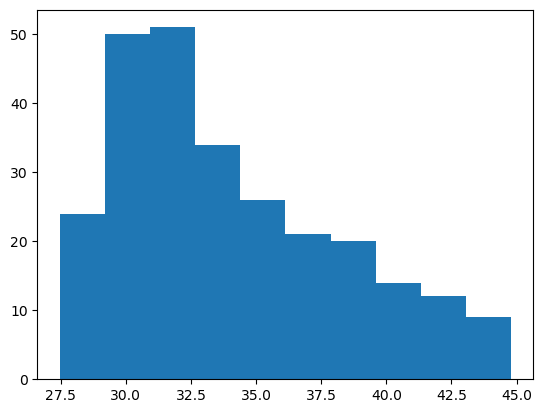

In [152]:
#histogramme des temps de traj de 2018-2022
traj_time_5y=traj_time_2018+traj_time_2019+traj_time_2020+traj_time_2021+traj_time_2022

plt.hist(traj_time_5y);

<font color = "purple"> Cet histogramme correspond aux temps de trajets de 2018-2022. Ainsi, les temps de trajets fluctuent entre 27,5h et un peu moins de 45 heures. On observe que la plupart des trajets durent entre 29 et 32,5 heures alors que le temps de trajet sans vent est de 32h50. Ainsi, on peut penser qu'une certaine disposition de vent a un rôle bénéfique sur le temps de trajet puisqu'il est peut être plus cours avec vent que sans vent. nous allons donc déterminer dans la suite quelles sont ces conditions de vent dites "favorables".

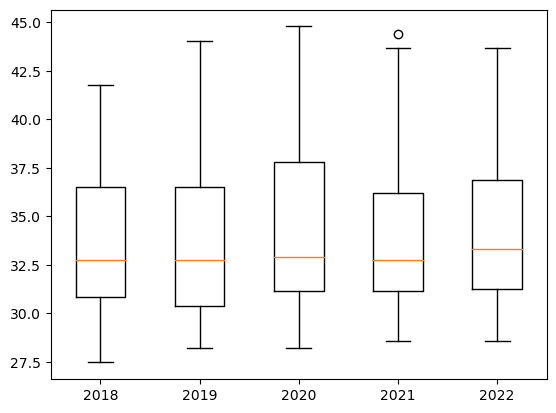

In [153]:
traj_time_5y=[traj_time_2018,traj_time_2019,traj_time_2020,traj_time_2021,traj_time_2022]

plt.boxplot(traj_time_5y,labels=years);

In [154]:
windspeed_2018=get_windspeed_days(u_v_time_opt_2018_base)
windspeed_2019=get_windspeed_days(u_v_time_opt_2019_base)
windspeed_2020=get_windspeed_days(u_v_time_opt_2020_base)
windspeed_2021=get_windspeed_days(u_v_time_opt_2021_base)
windspeed_2022=get_windspeed_days(u_v_time_opt_2022_base)
windspeed_5y=[windspeed_2018,windspeed_2019,windspeed_2020,windspeed_2021,windspeed_2022]

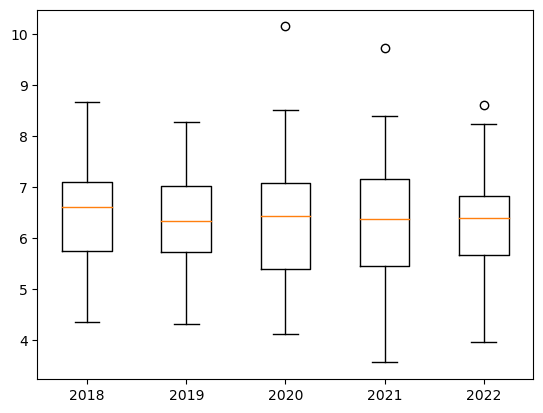

In [155]:
plt.boxplot(windspeed_5y,labels=years);


In [156]:
winddir_2018=get_winddir_days(u_v_time_opt_2018_base)
winddir_2019=get_winddir_days(u_v_time_opt_2019_base)
winddir_2020=get_winddir_days(u_v_time_opt_2020_base)
winddir_2021=get_winddir_days(u_v_time_opt_2021_base)
winddir_2022=get_winddir_days(u_v_time_opt_2022_base)
winddir_5y=[winddir_2018,winddir_2019,winddir_2020,winddir_2021,winddir_2022]

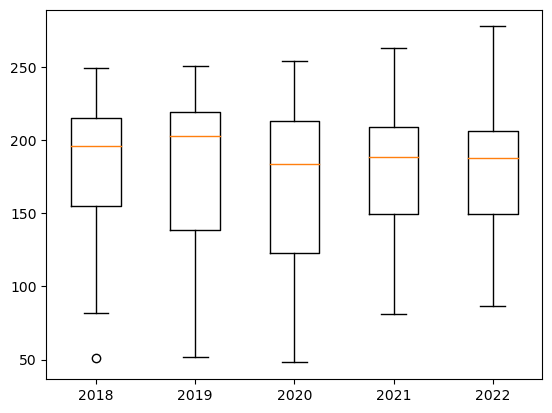

In [157]:
plt.boxplot(winddir_5y,labels=years);


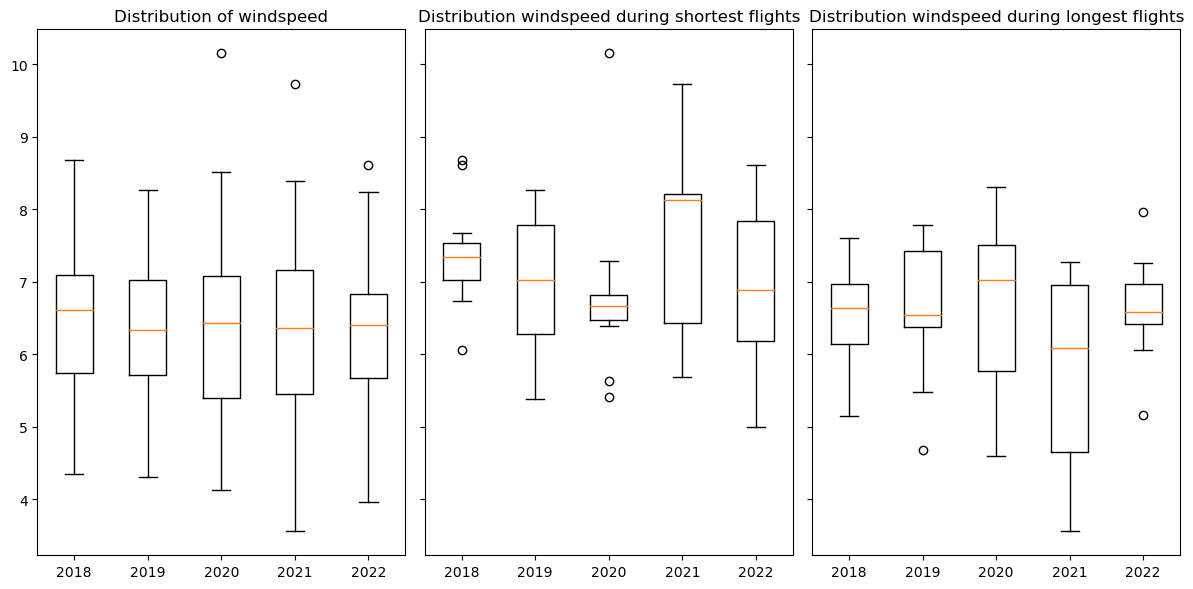

In [158]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 6))

axes[0].boxplot(windspeed_5y,labels=years)
axes[0].set_title('Distribution of windspeed')

axes[1].boxplot(windspeed_best_5y,labels=years)
axes[1].set_title('Distribution windspeed during shortest flights')

axes[2].boxplot(windspeed_worst_5y,labels=years)
axes[2].set_title('Distribution windspeed during longest flights')

# Show the plot
plt.tight_layout()
plt.show()

<font color = "purple"> La vitesse de vent moyenne chaque année est semblable : entre 6.5 et 7 m/s. Pour ce qui est des temps de trajet les plus courts, le vitesse moyenne de ces trajets varie de 6.5 à 8, elle est donc supérieur ou égale en moyenne avec la vitesse moyenne sur l'année. Pour les temps de trajet les plus long, elle varie de 6 à 7, elle est donc en moyenne inférieur ou égle à la moyenne sur les 5 ans mais il n'y a pas une différénce de vitesse de vent très marquéee entre les meilleurs et les pires trajets, ce qui nous paraît cohérent car il faut aussi prendre en compte la direction du vent : même si la vitesse du vent un jour donné est dans la moyenne des vitesse de l'année, si la direction du vent est dans le sens opposé à notre aéronef, le tremps de trajet sera normalement assez long, verifions le :

In [159]:
winddir_5y=list(winddir_2018)+list(winddir_2019)+list(winddir_2020)+list(winddir_2021)+list(winddir_2022)
winddir_best_5y=list(winddir_best_2018)+list(winddir_best_2019)+list(winddir_best_2020)+list(winddir_best_2021)+list(winddir_best_2022)
winddir_worst_5y=list(winddir_worst_2018)+list(winddir_worst_2019)+list(winddir_worst_2020)+list(winddir_worst_2021)+list(winddir_worst_2022)

traj_time_5y=traj_time_2018+traj_time_2019+traj_time_2020+traj_time_2021+traj_time_2022
traj_time_best_5y=traj_time_best_2018+traj_time_best_2019+traj_time_best_2020+traj_time_best_2021+traj_time_best_2022

windspeed_5y=list(windspeed_2018)+list(windspeed_2019)+list(windspeed_2020)+list(windspeed_2021)+list(windspeed_2022)
windspeed_best_5y=list(windspeed_best_2018)+list(windspeed_best_2019)+list(windspeed_best_2020)+list(windspeed_best_2021)+list(windspeed_best_2022)
windspeed_worst_5y=list(windspeed_worst_2018)+list(windspeed_worst_2019)+list(windspeed_worst_2020)+list(windspeed_worst_2021)+list(windspeed_worst_2022)



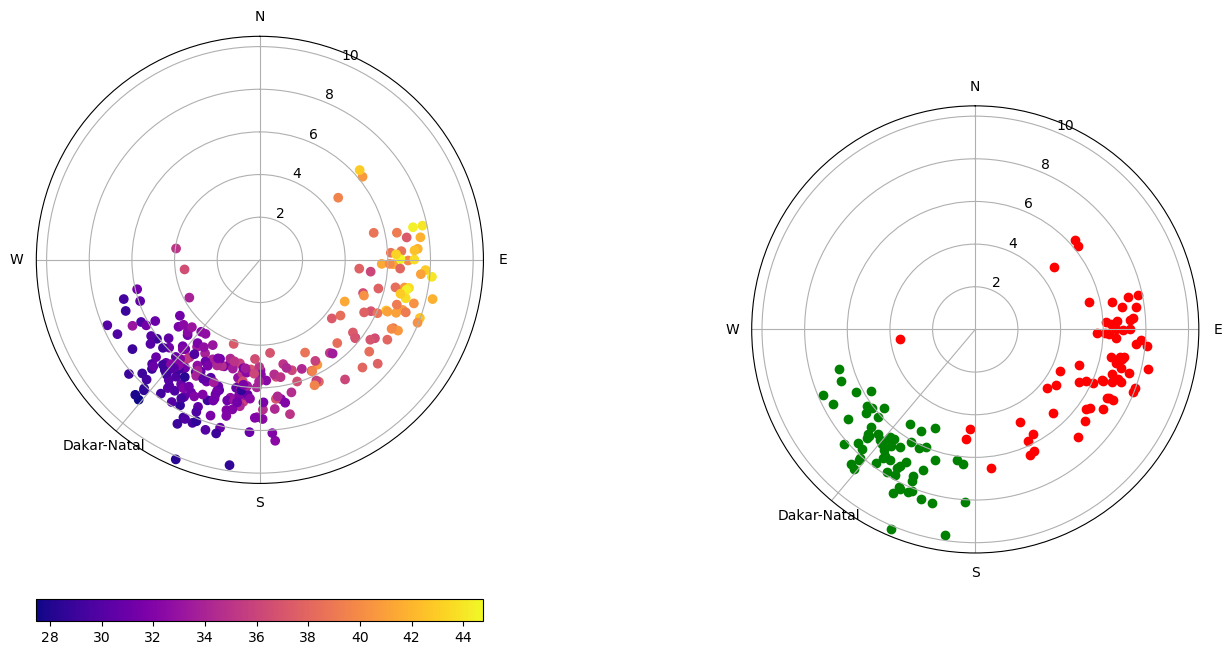

In [160]:
#wind fields (directions = angles, windspeed = length) during trajectories 2018-2022
#left = all trajectories colored by their traj time
#right = shortest 25% traj (green) and 15% longest (red)
winddir_5y_rad=np.radians(winddir_5y)
winddir_best_5y_rad=np.radians(winddir_best_5y)
winddir_worst_5y_rad=np.radians(winddir_worst_5y)


indices=windspeed_5y
indices_best=windspeed_best_5y
indices_worst=windspeed_worst_5y

fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw=dict(polar=True))


for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)

c0 = axes[0].scatter(winddir_5y_rad, indices, c=traj_time_5y, cmap='plasma')
axes[0].set_xticks(np.radians([0, 90, 180,220, 270]))
axes[0].set_xticklabels(['N', 'E', 'S','Dakar-Natal', 'W'])

c1=axes[1].scatter(winddir_best_5y_rad, indices_best, color='green')
axes[1].set_xticks(np.radians([0, 90, 180,220, 270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])

c2=axes[1].scatter(winddir_worst_5y_rad, indices_worst, color='red')
axes[1].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])

fig.colorbar(c0, ax=axes[0], orientation='horizontal')




plt.subplots_adjust(wspace=0.6)
plt.show()

<font color = "purple"> Ces graphiques représentent les champs de vent (directions = angles, vitesse du vent =longueur) pour les trajectoires entre 2018 et 2022 (compris). Sur la graphique de gauche, on peut voir l'ensemble des trajectoires sur les 5 ans, colorés en fonction de leurs temps de trajet. En opposition, nous avont exposé sur le graphique de gauche les 13 trajets les plus courts en verts et les 13 plus longs en rouge.
    
 graphique de gauche : Sur ce graphe, on peut voir que les trajectoires avec les temps de trajets les plus courts (en violet foncé) se trouvent, pour tous les ans, dans le cadran entre l'Ouest et le Sud et entre la COUCHE 6 ET 10. Cela signifie que, les jours où le temps de trajet a été minimum, les conditions de vent étaient : vent dans la direction Sud-Ouest avec un vitesse assez forte : de 6 à 10m/s, ce qui est cohérent avec notre analyse précédente. C'est confirmé par le graphique de roite aussi.

 Pour ces qui est de trajectoires avec les temps de trajet le plus long, elles correspondent, comme on peut le voir sur la graphique de droite, à une direction de vent plutôt vers le Sud Ouest ou vers l'Est et à une vitesse de vent plutôt moyenne à faible : entre 4 et 7.5 m/s.
    On peut aussi analyser que les trajectoires avec un temps de trajet moyen (en rose et orange sur le graphique de gauche) correspondent à une vitessse de vent plutôt moyenne : entre 4 et 8 m/s et à une direction de vent différente de celle du Sud_Ouest (216).
    
On peut aussi voir que dans cette région, ils n'y a pas de vent dirigé dans la direction opposé à la trajectoire Dakar- Natal ( environ 36 degrès) : abscence de vent entre le Nord et l'Ouest et quasiment pas dns la direction nord est non plus. ce phénomène peut être expliqué par : (PAS LE SUJET DE NOTRE ETUDE?) :

- Influence des alizés : La région entre Dakar et Natal peut être soumise à l'influence des alizés, des vents prédominants qui soufflent des régions subtropicales vers l'équateur. Dans l'hémisphère sud, les alizés soufflent généralement du sud-est vers le nord-ouest. Cela signifie que les vents dominants dans la région peuvent être orientés du sud-est plutôt que du nord-ouest ou du nord-est.

- Topographie côtière : La configuration géographique de la côte atlantique peut influencer les schémas de vent locaux. Par exemple, la présence de chaînes de montagnes, de dunes de sable ou d'autres formations géographiques peut provoquer des turbulences et des changements de direction du vent. Ces caractéristiques topographiques peuvent perturber les vents et rendre moins fréquents les vents dominants dans les directions nord-ouest ou nord-est.
    

In [161]:
dates_best_2022=[key for key in data_best_2022.keys()]
dates_best_2021=[key for key in data_best_2021.keys()]
dates_best_2020=[key for key in data_best_2020.keys()]
dates_best_2019=[key for key in data_best_2019.keys()]
dates_best_2018=[key for key in data_best_2018.keys()]
dates_best_5y=dates_best_2022+ dates_best_2021+   dates_best_2020+    dates_best_2019+ dates_best_2018  


In [162]:
data_best_5y={**data_best_2018,**data_best_2019,**data_best_2020,**data_best_2021,**data_best_2022}
date_traj_best_5y=get_date_time(data_best_5y)

In [163]:
data_5y={**u_v_time_opt_2018,**u_v_time_opt_2019,**u_v_time_opt_2020,**u_v_time_opt_2021,**u_v_time_opt_2022}
date_traj_5y=get_date_time(data_5y)

In [164]:
data_worst_5y={**data_worst_2018,**data_worst_2019,**data_worst_2020,**data_worst_2021,**data_worst_2022}
date_traj_worst_5y=get_date_time(data_worst_5y)

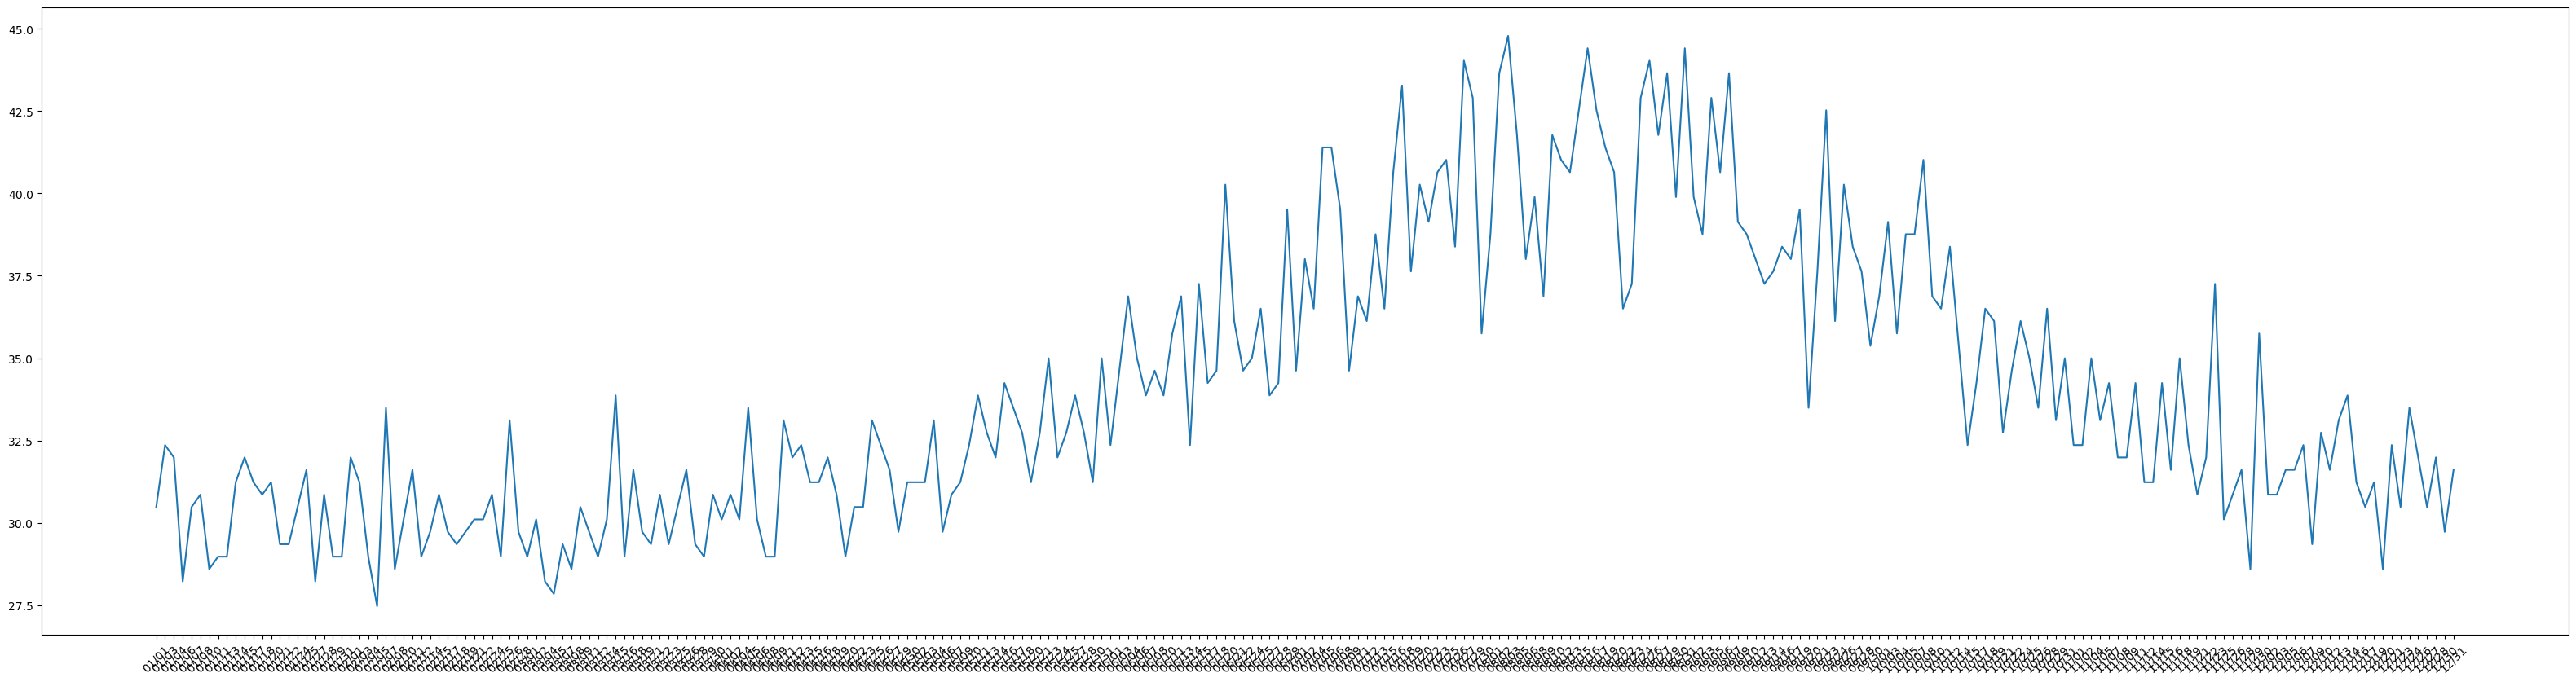

In [165]:
#all time traj over 5 years 
plt.figure(figsize=(40, 10))
plt.plot(list(date_traj_5y.keys()), [v[-1] for v in date_traj_5y.values()], '-')
plt.xticks(rotation=45)
plt.show()


In [166]:
date_traj_best_5y.keys()

dict_keys(['01/01', '01/06', '01/08', '01/10', '01/11', '01/13', '01/17', '01/18', '01/21', '01/22', '01/24', '01/27', '01/29', '01/31', '02/04', '02/05', '02/08', '02/10', '02/12', '02/14', '02/15', '02/17', '02/18', '02/19', '02/21', '02/22', '02/24', '02/25', '02/28', '03/01', '03/02', '03/04', '03/05', '03/07', '03/08', '03/09', '03/11', '03/12', '03/14', '03/16', '03/19', '03/21', '03/22', '03/23', '03/28', '03/29', '03/30', '04/01', '04/04', '04/06', '04/08', '04/09', '04/19', '04/20', '04/23', '04/29', '05/06', '11/21', '11/25', '11/29', '12/09', '12/17', '12/20', '12/27', '12/30'])

In [167]:
date_traj_worst_5y.keys()

dict_keys(['06/04', '06/20', '06/29', '07/02', '07/05', '07/06', '07/08', '07/13', '07/16', '07/18', '07/19', '07/20', '07/22', '07/23', '07/25', '07/26', '07/27', '07/29', '08/01', '08/02', '08/03', '08/05', '08/06', '08/08', '08/09', '08/10', '08/12', '08/13', '08/15', '08/16', '08/17', '08/19', '08/20', '08/23', '08/24', '08/26', '08/27', '08/29', '08/30', '08/31', '09/02', '09/03', '09/05', '09/06', '09/07', '09/09', '09/10', '09/12', '09/13', '09/16', '09/17', '09/19', '09/23', '09/26', '09/27', '10/01', '10/03', '10/05', '10/07', '10/08', '10/10', '10/11', '10/12', '10/18', '10/28'])

<font color = "purple"> Ici, on voit que les dates des trajets où le temps est minimal correspondent au mois de janvier à avril et de fin novemre à décembre. Pour ce qui est des pires temps de trajects, ils correspondent aux périodes entre juin et octobre. cela correspond bien à ce que l'on a énoncé dans la partie analyse saisonnière.

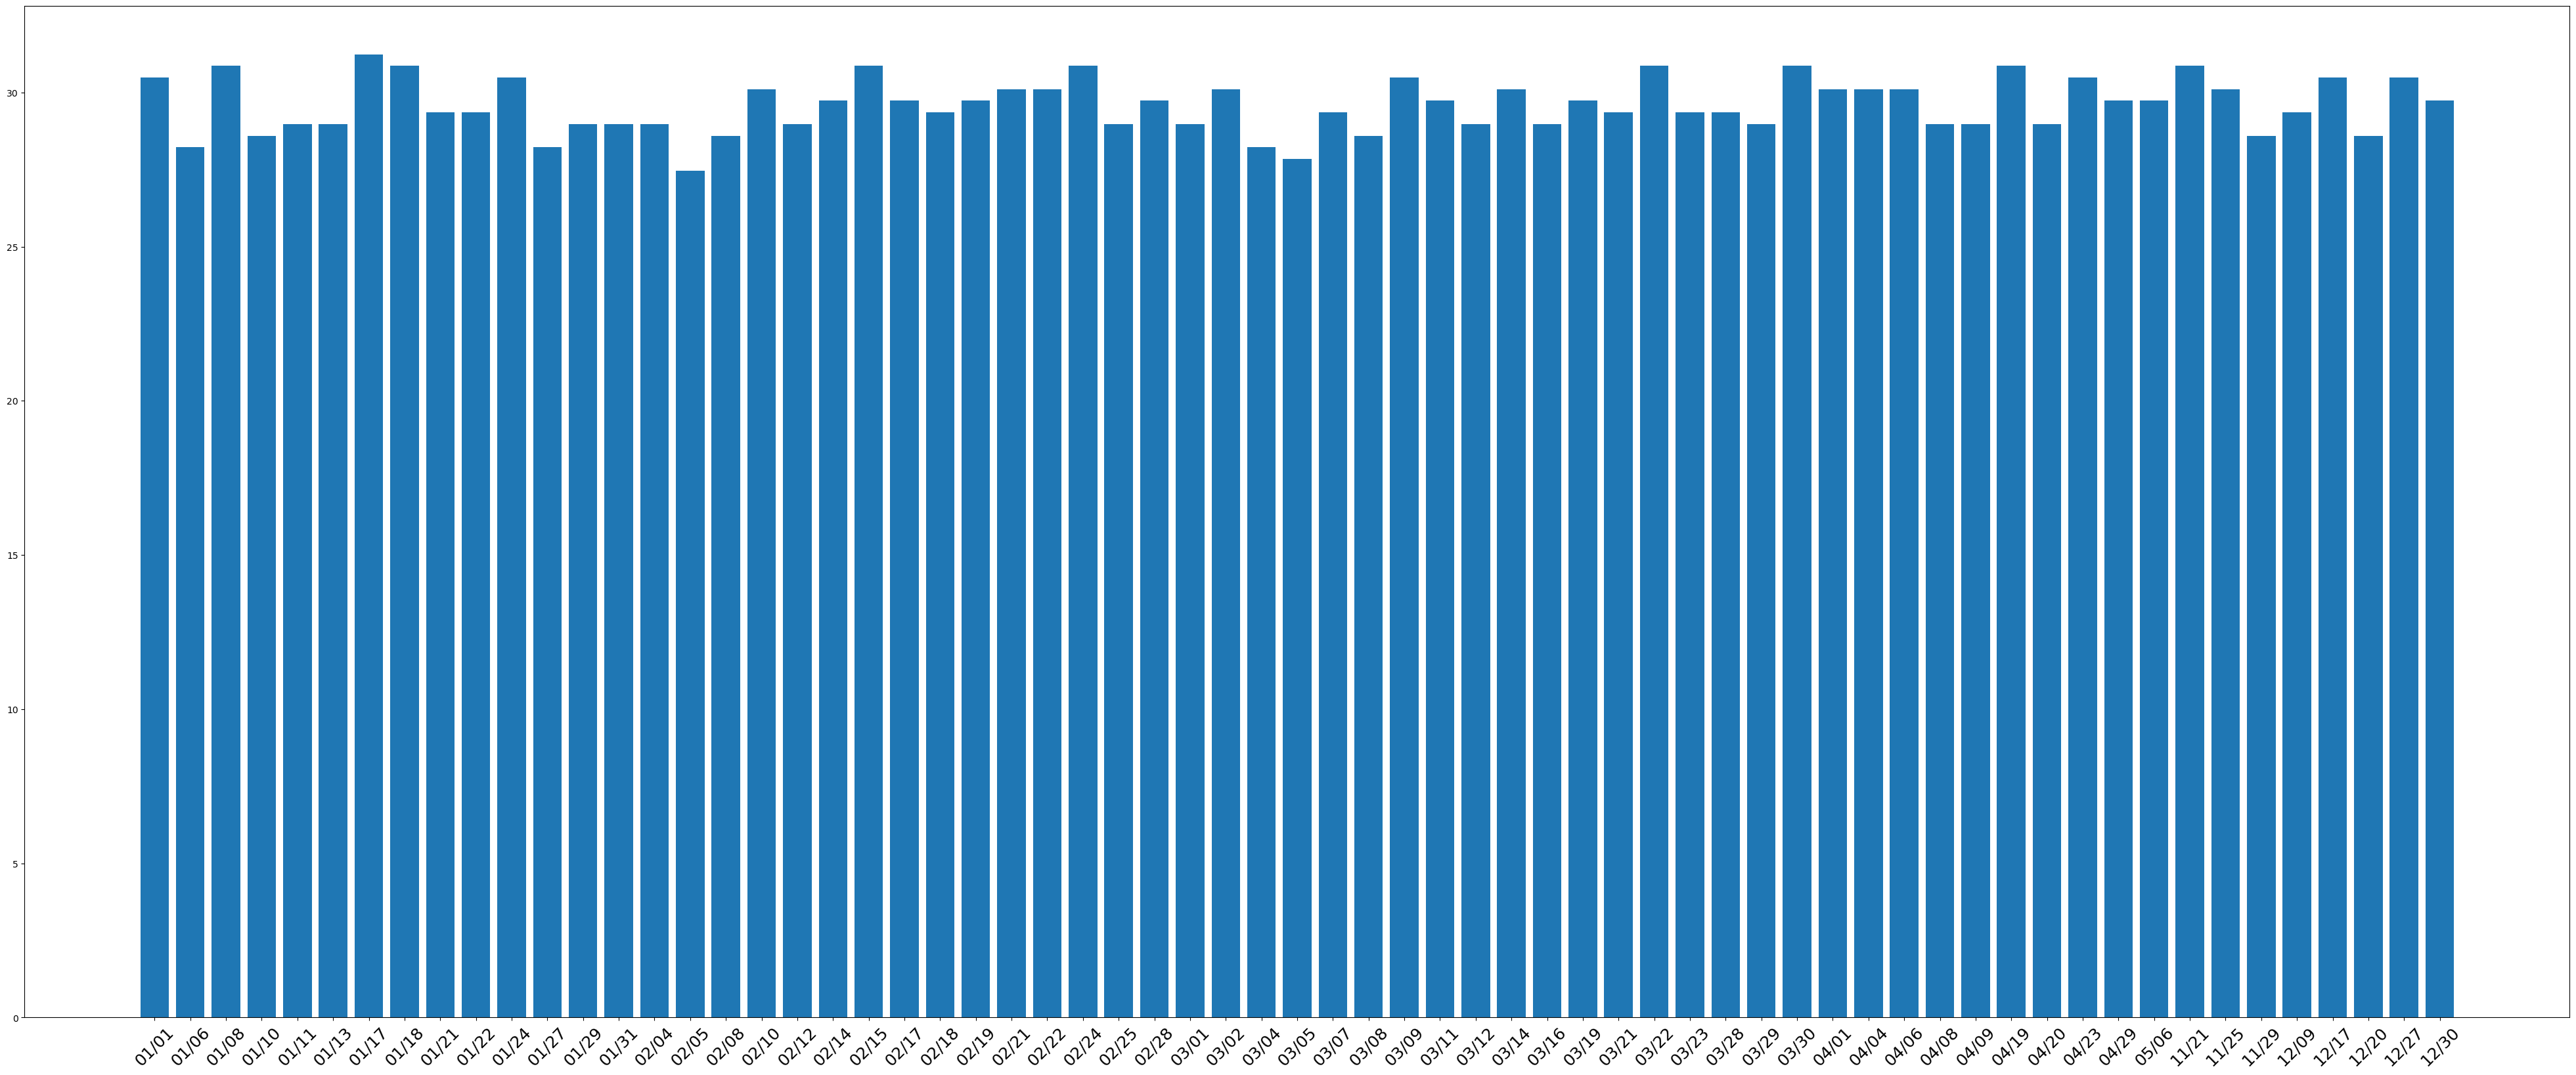

In [168]:
#Hist of shortest flights 
dates_best_5y = list(date_traj_best_5y.keys())
traj_time_best_5y = [v[-1] for v in date_traj_best_5y.values()]

plt.figure(figsize=(50, 20))
plt.bar(dates_best_5y, traj_time_best_5y)

plt.xticks(rotation=45,fontsize=18)
plt.show()

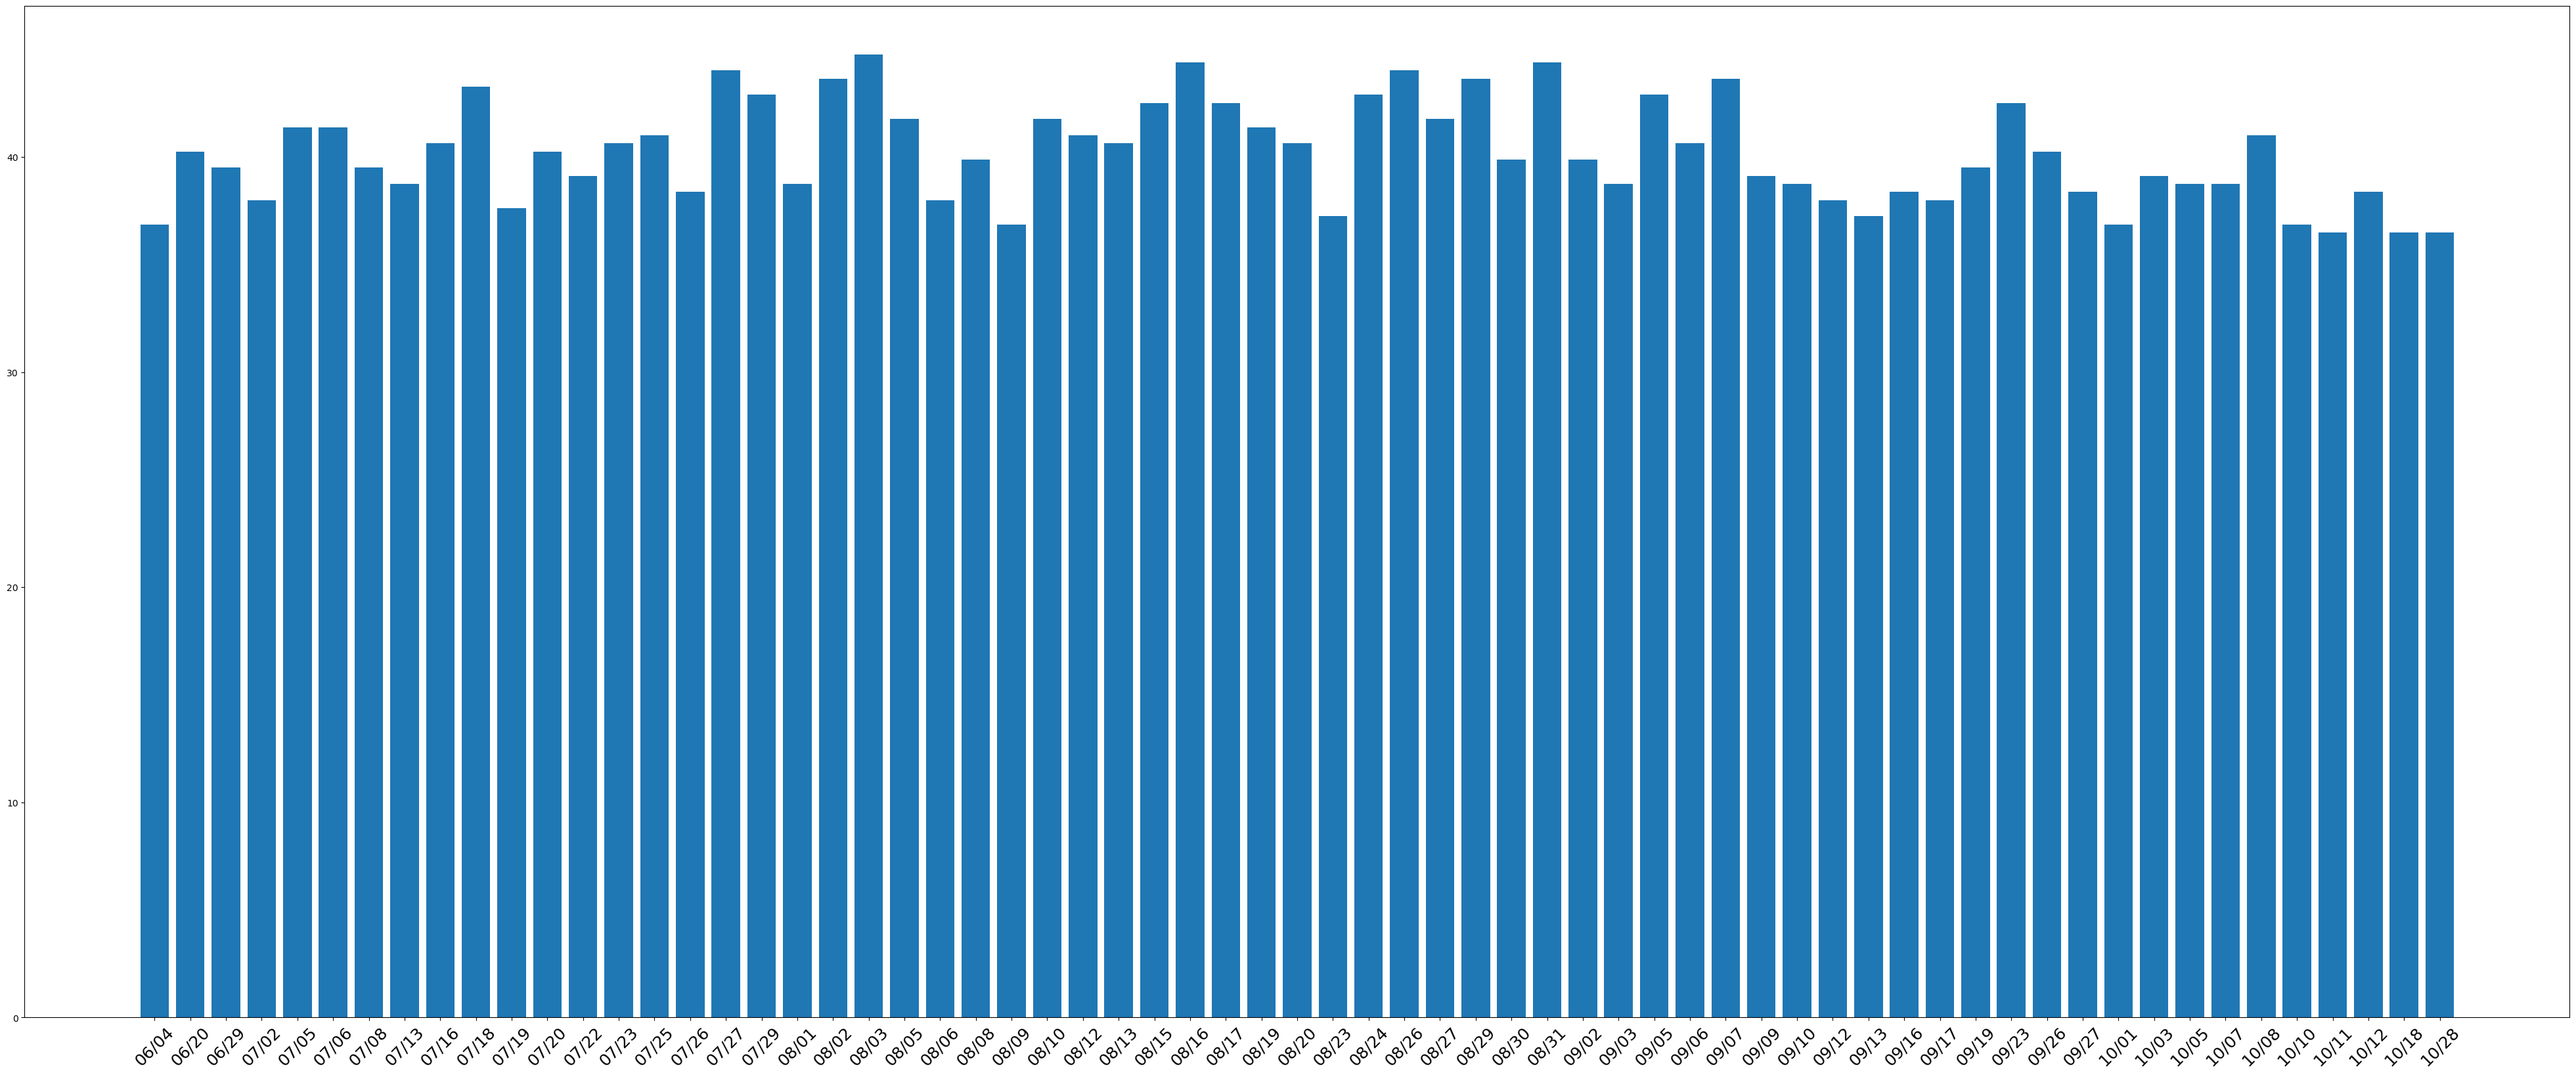

In [169]:
#Hist of longest flights 
dates_worst_5y = list(date_traj_worst_5y.keys())
traj_time_worst_5y = [v[-1] for v in date_traj_worst_5y.values()]

plt.figure(figsize=(50, 20))
plt.bar(dates_worst_5y, traj_time_worst_5y)

plt.xticks(rotation=45,fontsize=18)
plt.show()

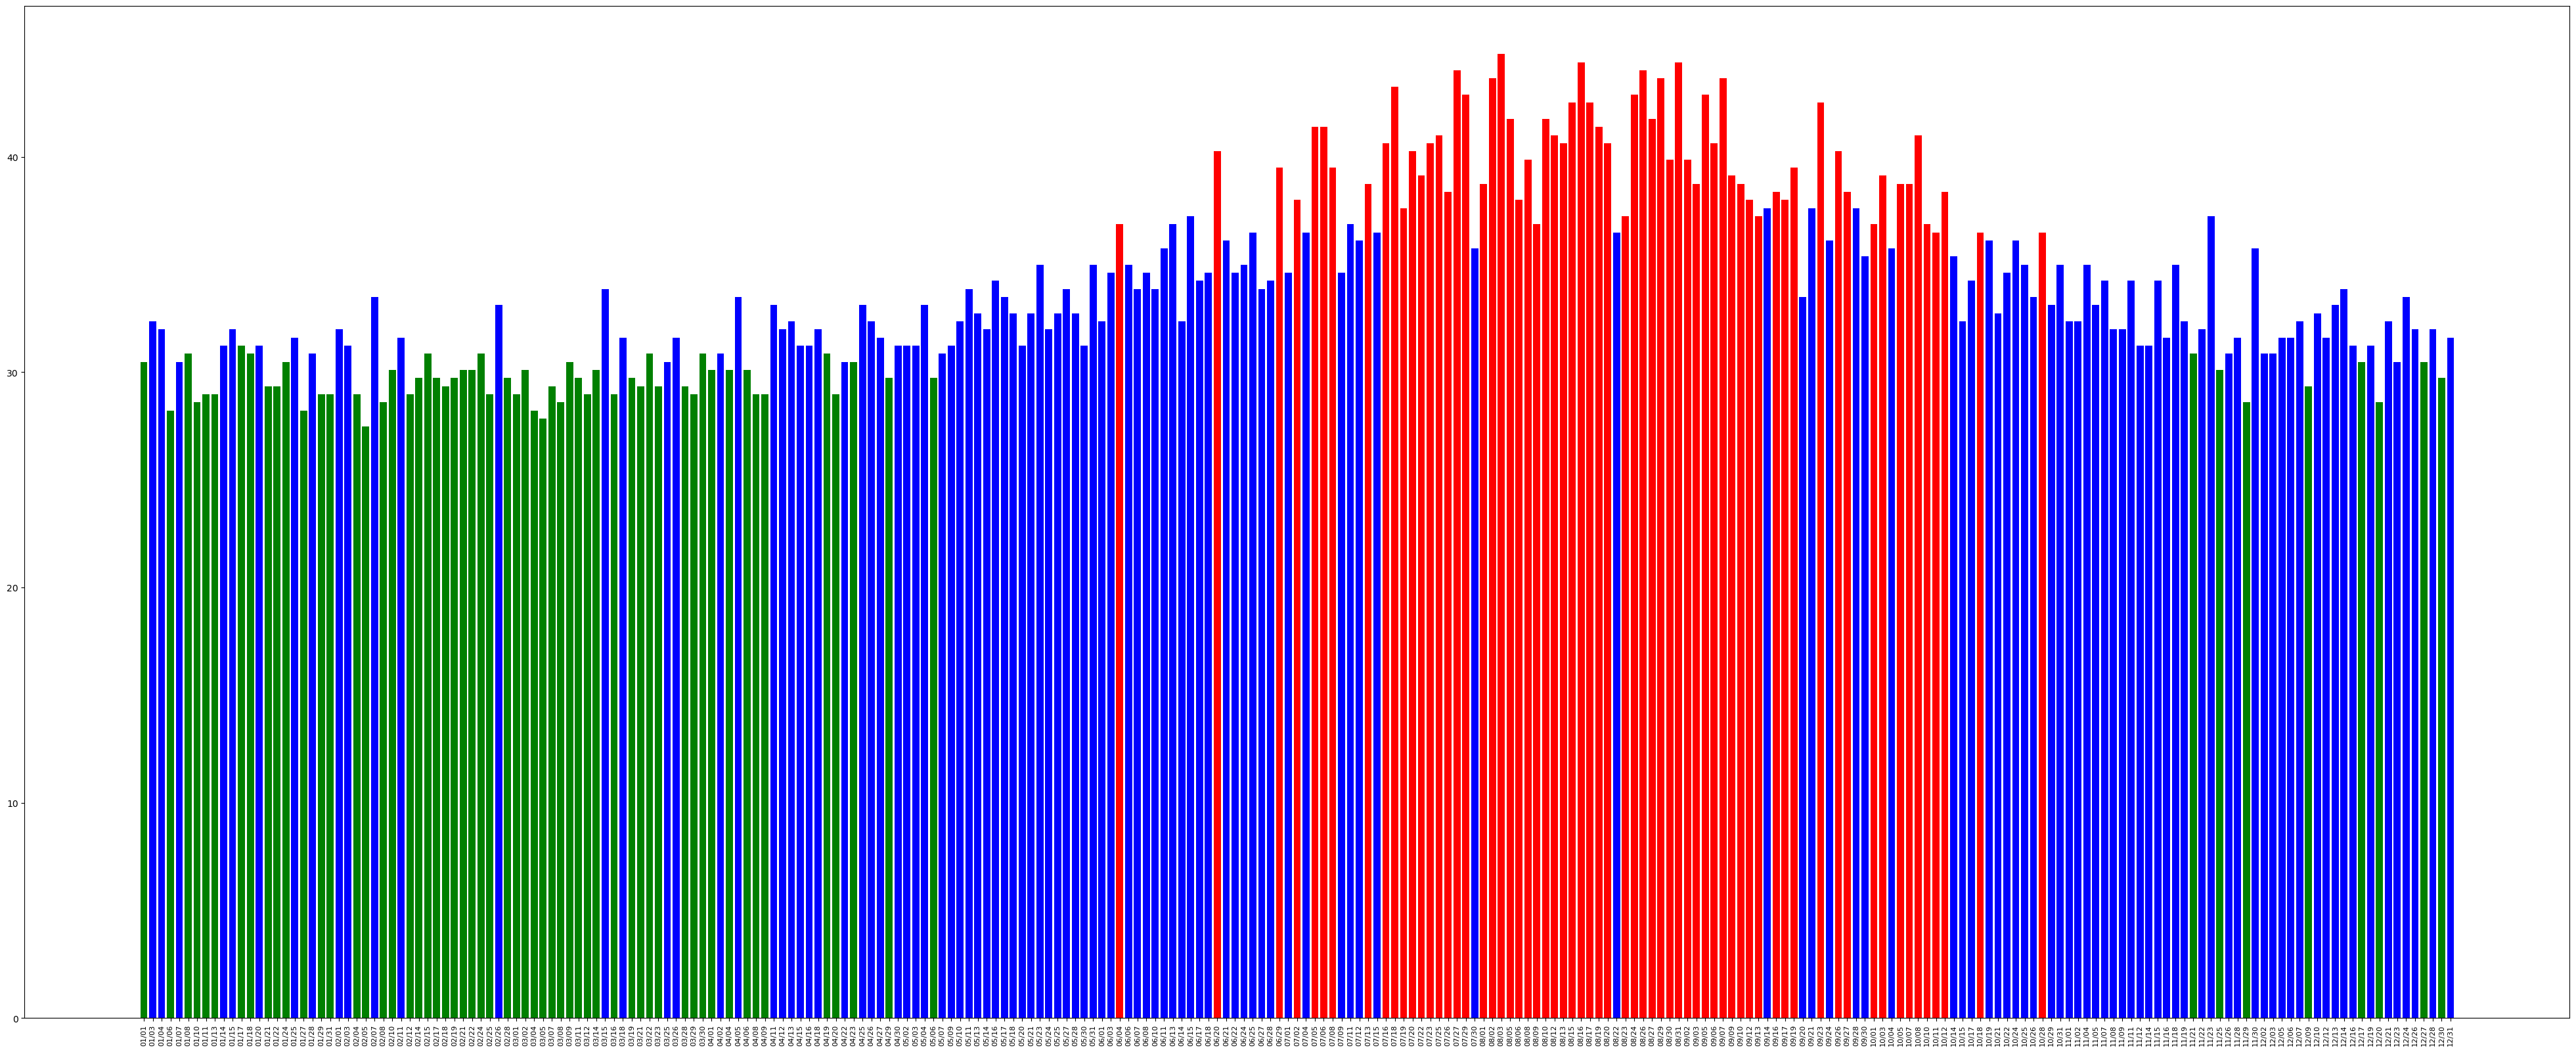

In [170]:
#ouvrir l'image dans nouvelle fenetre pour lire les dates
dates_5y = list(date_traj_5y.keys())
traj_time_5y = [v[-1] for v in date_traj_5y.values()]

colors = ['red' if date_5y in dates_worst_5y else 'green' if date_5y in dates_best_5y else 'blue' for date_5y in dates_5y]

plt.figure(figsize=(50, 20))
plt.bar(dates_5y, traj_time_5y, color=colors)
plt.xticks(rotation=90,fontsize=8)

plt.show()


In [171]:
u_v_time_opt_5y={**u_v_time_opt_2018,**u_v_time_opt_2019,**u_v_time_opt_2020,**u_v_time_opt_2021,**u_v_time_opt_2022}
data_5y=get_date_time(u_v_time_opt_5y)
df_5y = pd.DataFrame(data_5y).T
df_5y = df_5y.rename(columns={0: 'avg_traj_windspeed', 1: 'avg_traj_winddir', 2: 'traj_time'})
df_5y['date']=list(data_5y.keys())
df_5y

avg_traj_windspeed  avg_traj_winddir  traj_time   date
01/01            7.338417        208.931914  30.481941  01/01
01/03            6.524859        184.068606  32.363542  01/03
01/04            6.418087        188.749526  31.987222  01/04
01/06            6.525062        212.653496  28.224019  01/06
01/07            5.921531        207.945495  30.481941  01/07
...                   ...               ...        ...    ...
12/26            7.485453        192.139445  31.987222  12/26
12/27            6.398146        197.348871  30.481941  12/27
12/28            8.145012        175.895425  31.987222  12/28
12/30            5.382930        214.759287  29.729300  12/30
12/31            5.266487        198.583408  31.610901  12/31

[261 rows x 4 columns]

In [172]:
#save the dataframe
df_5y.to_csv('data_5y_DN.csv', index=False)

In [173]:
#read dataframe directly to avoid rerunning dict creation
df_5y = pd.read_csv('data_5y_DN.csv', sep = ",")
df_5y

avg_traj_windspeed  avg_traj_winddir  traj_time   date
0              7.338417        208.931914  30.481941  01/01
1              6.524859        184.068606  32.363542  01/03
2              6.418087        188.749526  31.987222  01/04
3              6.525062        212.653496  28.224019  01/06
4              5.921531        207.945495  30.481941  01/07
..                  ...               ...        ...    ...
256            7.485453        192.139445  31.987222  12/26
257            6.398146        197.348871  30.481941  12/27
258            8.145012        175.895425  31.987222  12/28
259            5.382930        214.759287  29.729300  12/30
260            5.266487        198.583408  31.610901  12/31

[261 rows x 4 columns]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9149d93ac0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9149d98610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9149d937f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9149d85520>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9149d857f0>],
 'means': []}

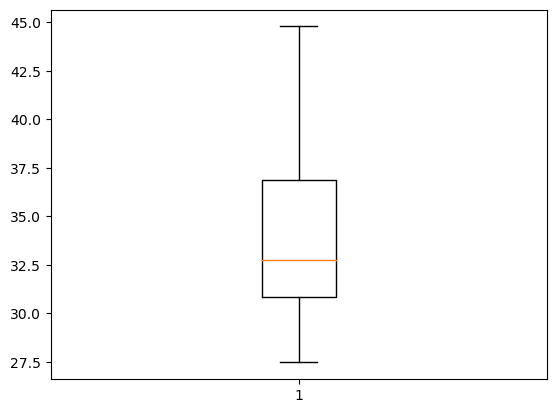

In [174]:
plt.boxplot(df_5y['traj_time'])

In [175]:
df_5y['month'] = df_5y['date'].str.slice(0, 2)


grouped_by_month = df_5y.groupby('month')
df_5y

avg_traj_windspeed  avg_traj_winddir  traj_time   date month
0              7.338417        208.931914  30.481941  01/01    01
1              6.524859        184.068606  32.363542  01/03    01
2              6.418087        188.749526  31.987222  01/04    01
3              6.525062        212.653496  28.224019  01/06    01
4              5.921531        207.945495  30.481941  01/07    01
..                  ...               ...        ...    ...   ...
256            7.485453        192.139445  31.987222  12/26    12
257            6.398146        197.348871  30.481941  12/27    12
258            8.145012        175.895425  31.987222  12/28    12
259            5.382930        214.759287  29.729300  12/30    12
260            5.266487        198.583408  31.610901  12/31    12

[261 rows x 5 columns]

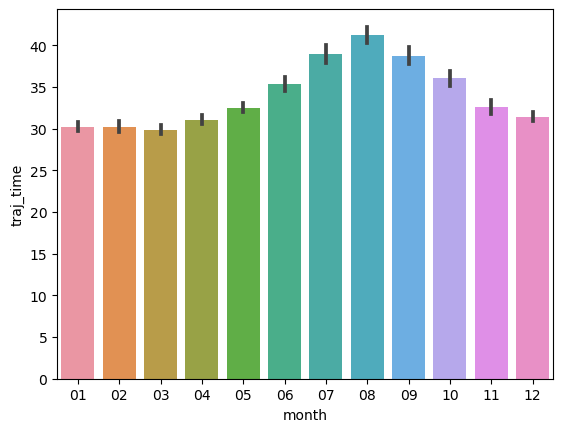

In [176]:
sns.barplot(x='month', y='traj_time', data=df_5y)
plt.show()

In [177]:
df_5y['date_dt'] = pd.to_datetime(df_5y['date'], format='%m/%d')
df_5y['semi_month'] = df_5y['date_dt'].apply(lambda dt: f"{dt.strftime('%B')}_1st_half" if dt.day <= 15 else f"{dt.strftime('%B')}_2nd_half")
df_5y = df_5y.drop(columns='date_dt')
df_5y


avg_traj_windspeed  avg_traj_winddir  traj_time   date month  \
0              7.338417        208.931914  30.481941  01/01    01   
1              6.524859        184.068606  32.363542  01/03    01   
2              6.418087        188.749526  31.987222  01/04    01   
3              6.525062        212.653496  28.224019  01/06    01   
4              5.921531        207.945495  30.481941  01/07    01   
..                  ...               ...        ...    ...   ...   
256            7.485453        192.139445  31.987222  12/26    12   
257            6.398146        197.348871  30.481941  12/27    12   
258            8.145012        175.895425  31.987222  12/28    12   
259            5.382930        214.759287  29.729300  12/30    12   
260            5.266487        198.583408  31.610901  12/31    12   

            semi_month  
0     January_1st_half  
1     January_1st_half  
2     January_1st_half  
3     January_1st_half  
4     January_1st_half  
..                 ...  
256  December_2nd_half  
257  December_2nd_half  
258  December_2nd_half  
259  December_2nd_half  
260  December_2nd_half  

[261 rows x 6 columns]

In [178]:
df_5y.to_csv('data_5y_DN_semi.csv', index=False)

In [179]:
#read dataframe directly to avoid rerunning dict creation
df_5y = pd.read_csv('data_5y_DN_semi.csv', sep = ",")
df_5y

avg_traj_windspeed  avg_traj_winddir  traj_time   date  month  \
0              7.338417        208.931914  30.481941  01/01      1   
1              6.524859        184.068606  32.363542  01/03      1   
2              6.418087        188.749526  31.987222  01/04      1   
3              6.525062        212.653496  28.224019  01/06      1   
4              5.921531        207.945495  30.481941  01/07      1   
..                  ...               ...        ...    ...    ...   
256            7.485453        192.139445  31.987222  12/26     12   
257            6.398146        197.348871  30.481941  12/27     12   
258            8.145012        175.895425  31.987222  12/28     12   
259            5.382930        214.759287  29.729300  12/30     12   
260            5.266487        198.583408  31.610901  12/31     12   

            semi_month  
0     January_1st_half  
1     January_1st_half  
2     January_1st_half  
3     January_1st_half  
4     January_1st_half  
..                 ...  
256  December_2nd_half  
257  December_2nd_half  
258  December_2nd_half  
259  December_2nd_half  
260  December_2nd_half  

[261 rows x 6 columns]

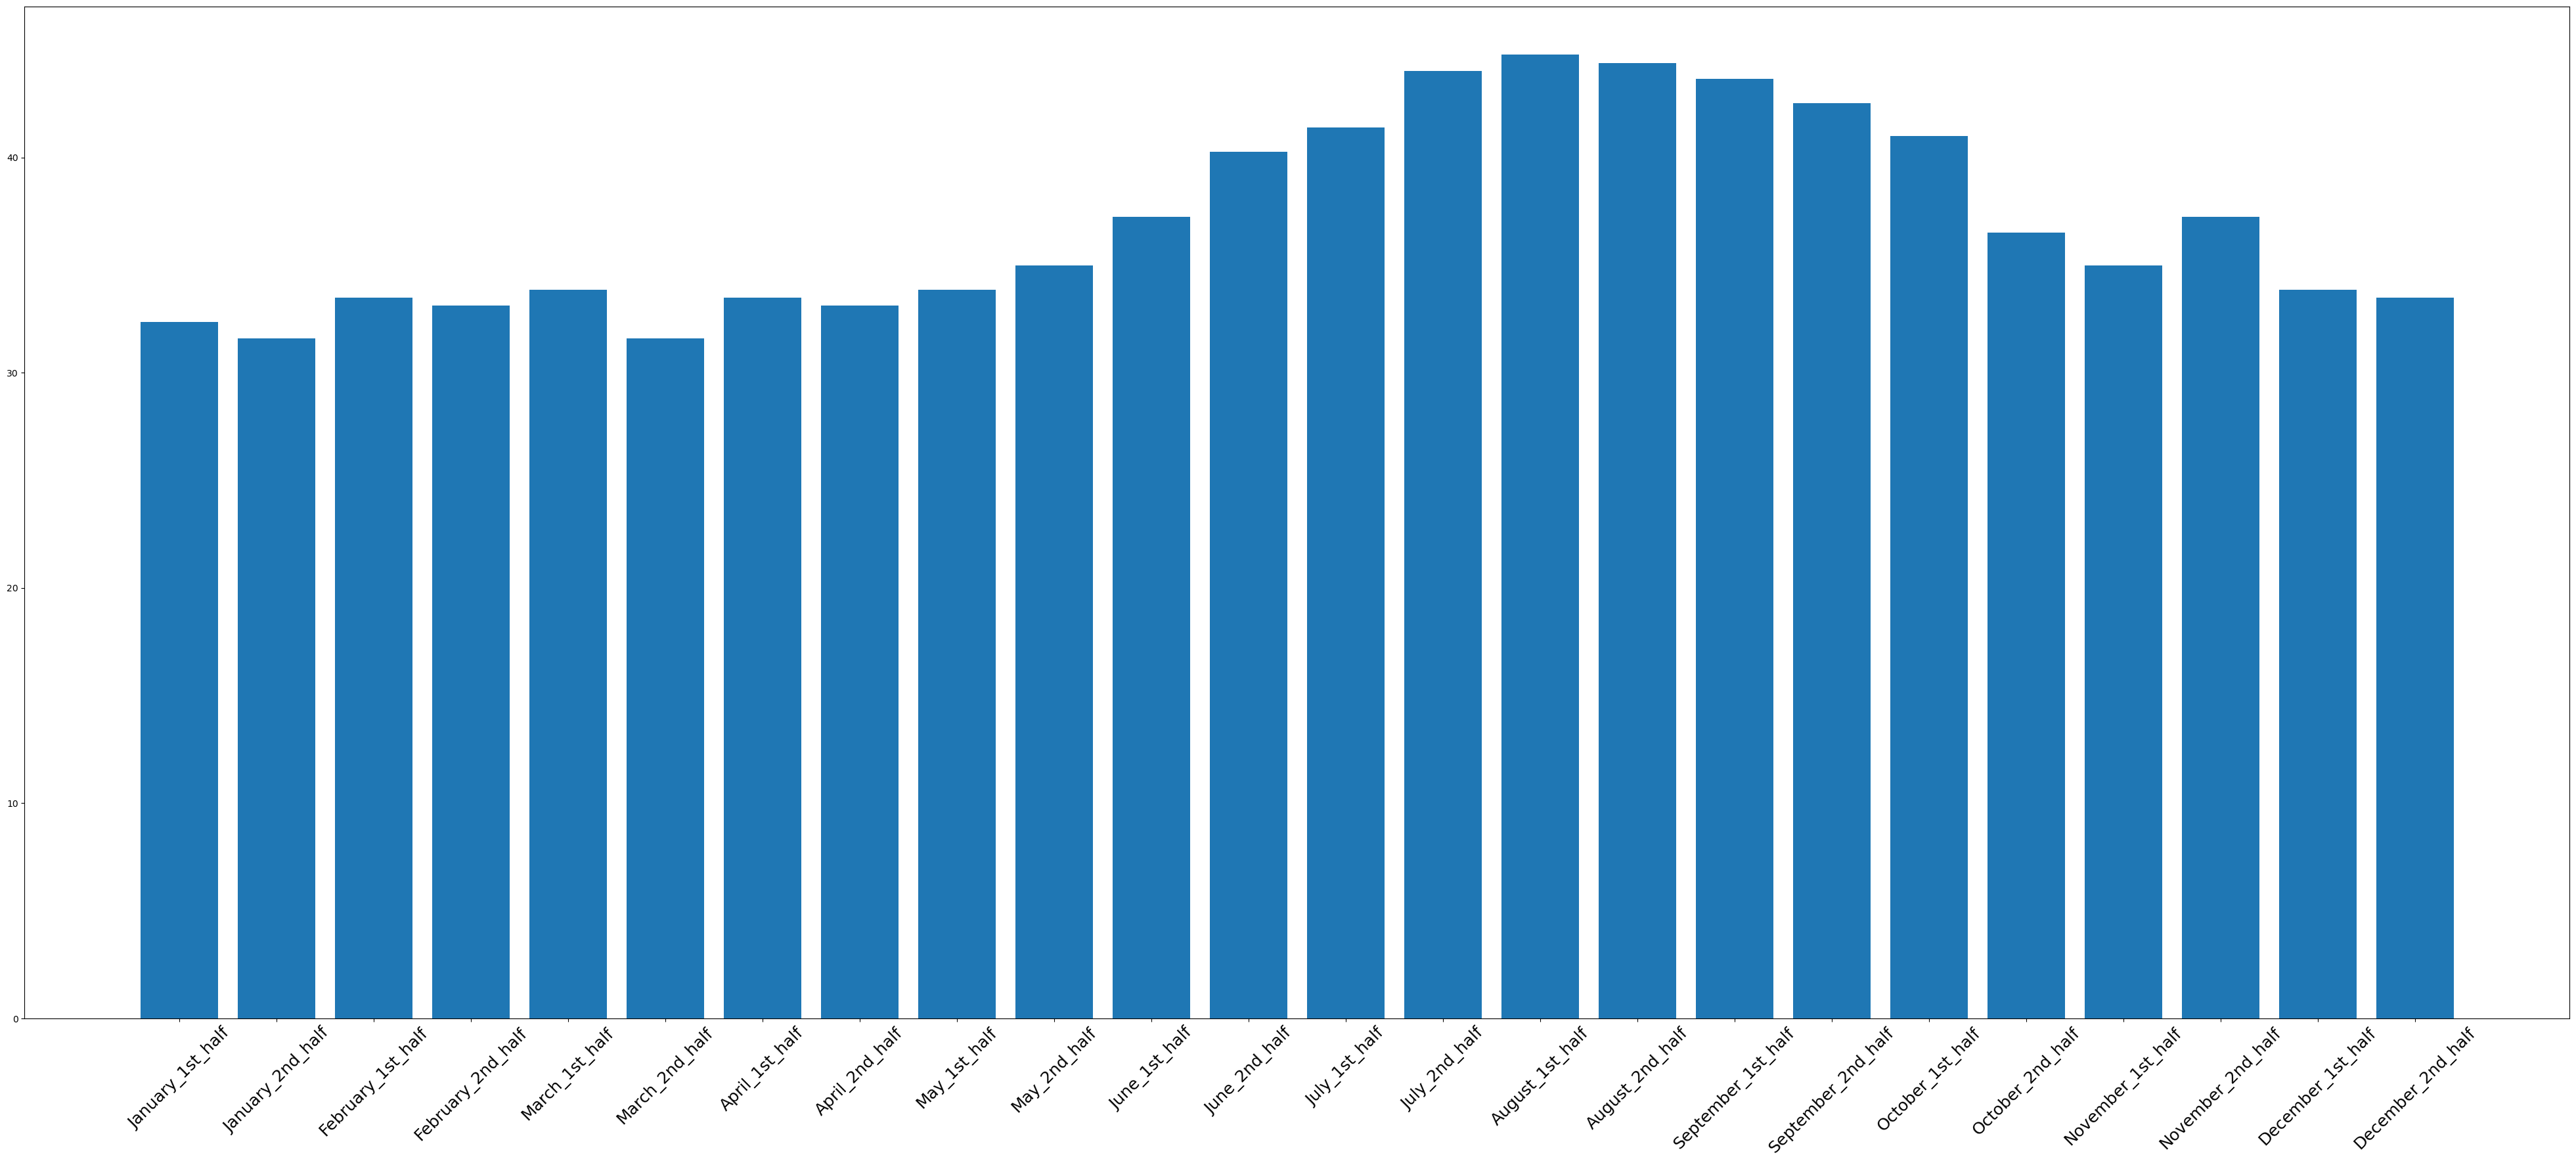

In [180]:
plt.figure(figsize=(50, 20))
plt.bar(df_5y['semi_month'], df_5y['traj_time'])

plt.xticks(rotation=45,fontsize=18)
plt.show()

<font color = "purple"> ce graphique confirme notre analyser saisonnière.

In [181]:
df_5y['semi_month'] = pd.Categorical(df_5y['semi_month'], categories=df_5y['semi_month'].unique(), ordered=True)
df_5y = df_5y.groupby('semi_month',sort=False).agg([ 'mean', 'min', 'max'])

/tmp/ipykernel_250986/77079523.py:2: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_5y = df_5y.groupby('semi_month',sort=False).agg([ 'mean', 'min', 'max'])


In [182]:
df_5y.to_csv('data_5y_DN_grouped.csv', index=True)

In [183]:
df_5y

avg_traj_windspeed                      avg_traj_winddir  \
                                 mean       min        max             mean   
semi_month                                                                    
January_1st_half             6.657265  5.429661   8.394290       203.274138   
January_2nd_half             6.726034  4.574227  10.152929       205.523644   
February_1st_half            6.719270  4.874481   8.676907       216.735805   
February_2nd_half            7.184980  4.566104   8.369250       217.242527   
March_1st_half               7.008045  3.751347   8.613431       223.820390   
March_2nd_half               6.378521  4.939658   8.142455       228.065288   
April_1st_half               6.529757  4.788014   7.784411       224.493074   
April_2nd_half               6.215666  4.484847   7.400849       220.218823   
May_1st_half                 6.303733  4.305133   7.024717       219.562111   
May_2nd_half                 5.602260  3.966113   7.128746       203.591847   
June_1st_half                5.283041  4.128072   6.703415       193.979456   
June_2nd_half                5.850268  4.832892   7.958075       176.374587   
July_1st_half                6.001732  4.430607   7.029062       131.455708   
July_2nd_half                6.783519  4.943092   8.104579       113.844270   
August_1st_half              6.952686  5.607335   8.304153       107.382766   
August_2nd_half              6.806910  5.082403   7.982105        85.513002   
September_1st_half           6.577384  4.350283   7.364998       101.780723   
September_2nd_half           5.752653  4.677526   6.487137       128.078329   
October_1st_half             5.548065  4.351452   6.853787       148.414721   
October_2nd_half             5.808287  3.559866   7.379266       172.946586   
November_1st_half            6.174307  5.024385   7.214995       179.704121   
November_2nd_half            6.817713  5.533573   8.130514       180.950500   
December_1st_half            6.390558  5.016630   7.803238       194.588124   
December_2nd_half            6.871736  5.029889   9.729515       196.271517   

                                            traj_time                        \
                           min         max       mean        min        max   
semi_month                                                                    
January_1st_half    184.068606  221.781655  30.379308  28.224019  32.363542   
January_2nd_half    185.200923  235.072320  30.105620  28.224019  31.610901   
February_1st_half   185.778176  249.152811  30.276675  27.471379  33.492503   
February_2nd_half   197.755219  242.456914  30.189247  28.976660  33.116182   
March_1st_half      205.868802  241.844223  29.660878  27.847699  33.868823   
March_2nd_half      208.148233  253.928776  30.105620  28.976660  31.610901   
April_1st_half      200.648425  246.784424  31.029315  28.976660  33.492503   
April_2nd_half      198.089130  242.395152  31.097737  28.976660  33.116182   
May_1st_half        190.404336  256.536847  31.836693  29.729300  33.868823   
May_2nd_half        167.375588  277.731110  33.084822  31.234581  34.997784   
June_1st_half       166.606926  229.619219  34.860940  32.363542  37.255705   
June_2nd_half       111.732399  215.825299  35.900952  33.868823  40.266267   
July_1st_half        51.568801  187.997870  37.666236  34.621463  41.395228   
July_2nd_half        87.662754  190.910164  40.334689  35.750424  44.029470   
August_1st_half      85.994180  151.296459  40.882064  36.879385  44.782110   
August_2nd_half      48.016686  109.959941  41.614748  36.503065  44.405790   
September_1st_half   78.781490  131.382314  39.664155  37.255705  43.653149   
September_2nd_half   95.053479  156.450331  37.939924  33.492503  42.524189   
October_1st_half     76.643356  219.198889  37.255705  32.363542  41.018908   
October_2nd_half     96.076789  262.758302  34.860940  32.739862  36.503065   
November_1st_half   158.961790  198.350918  32.910917  31.234581  34

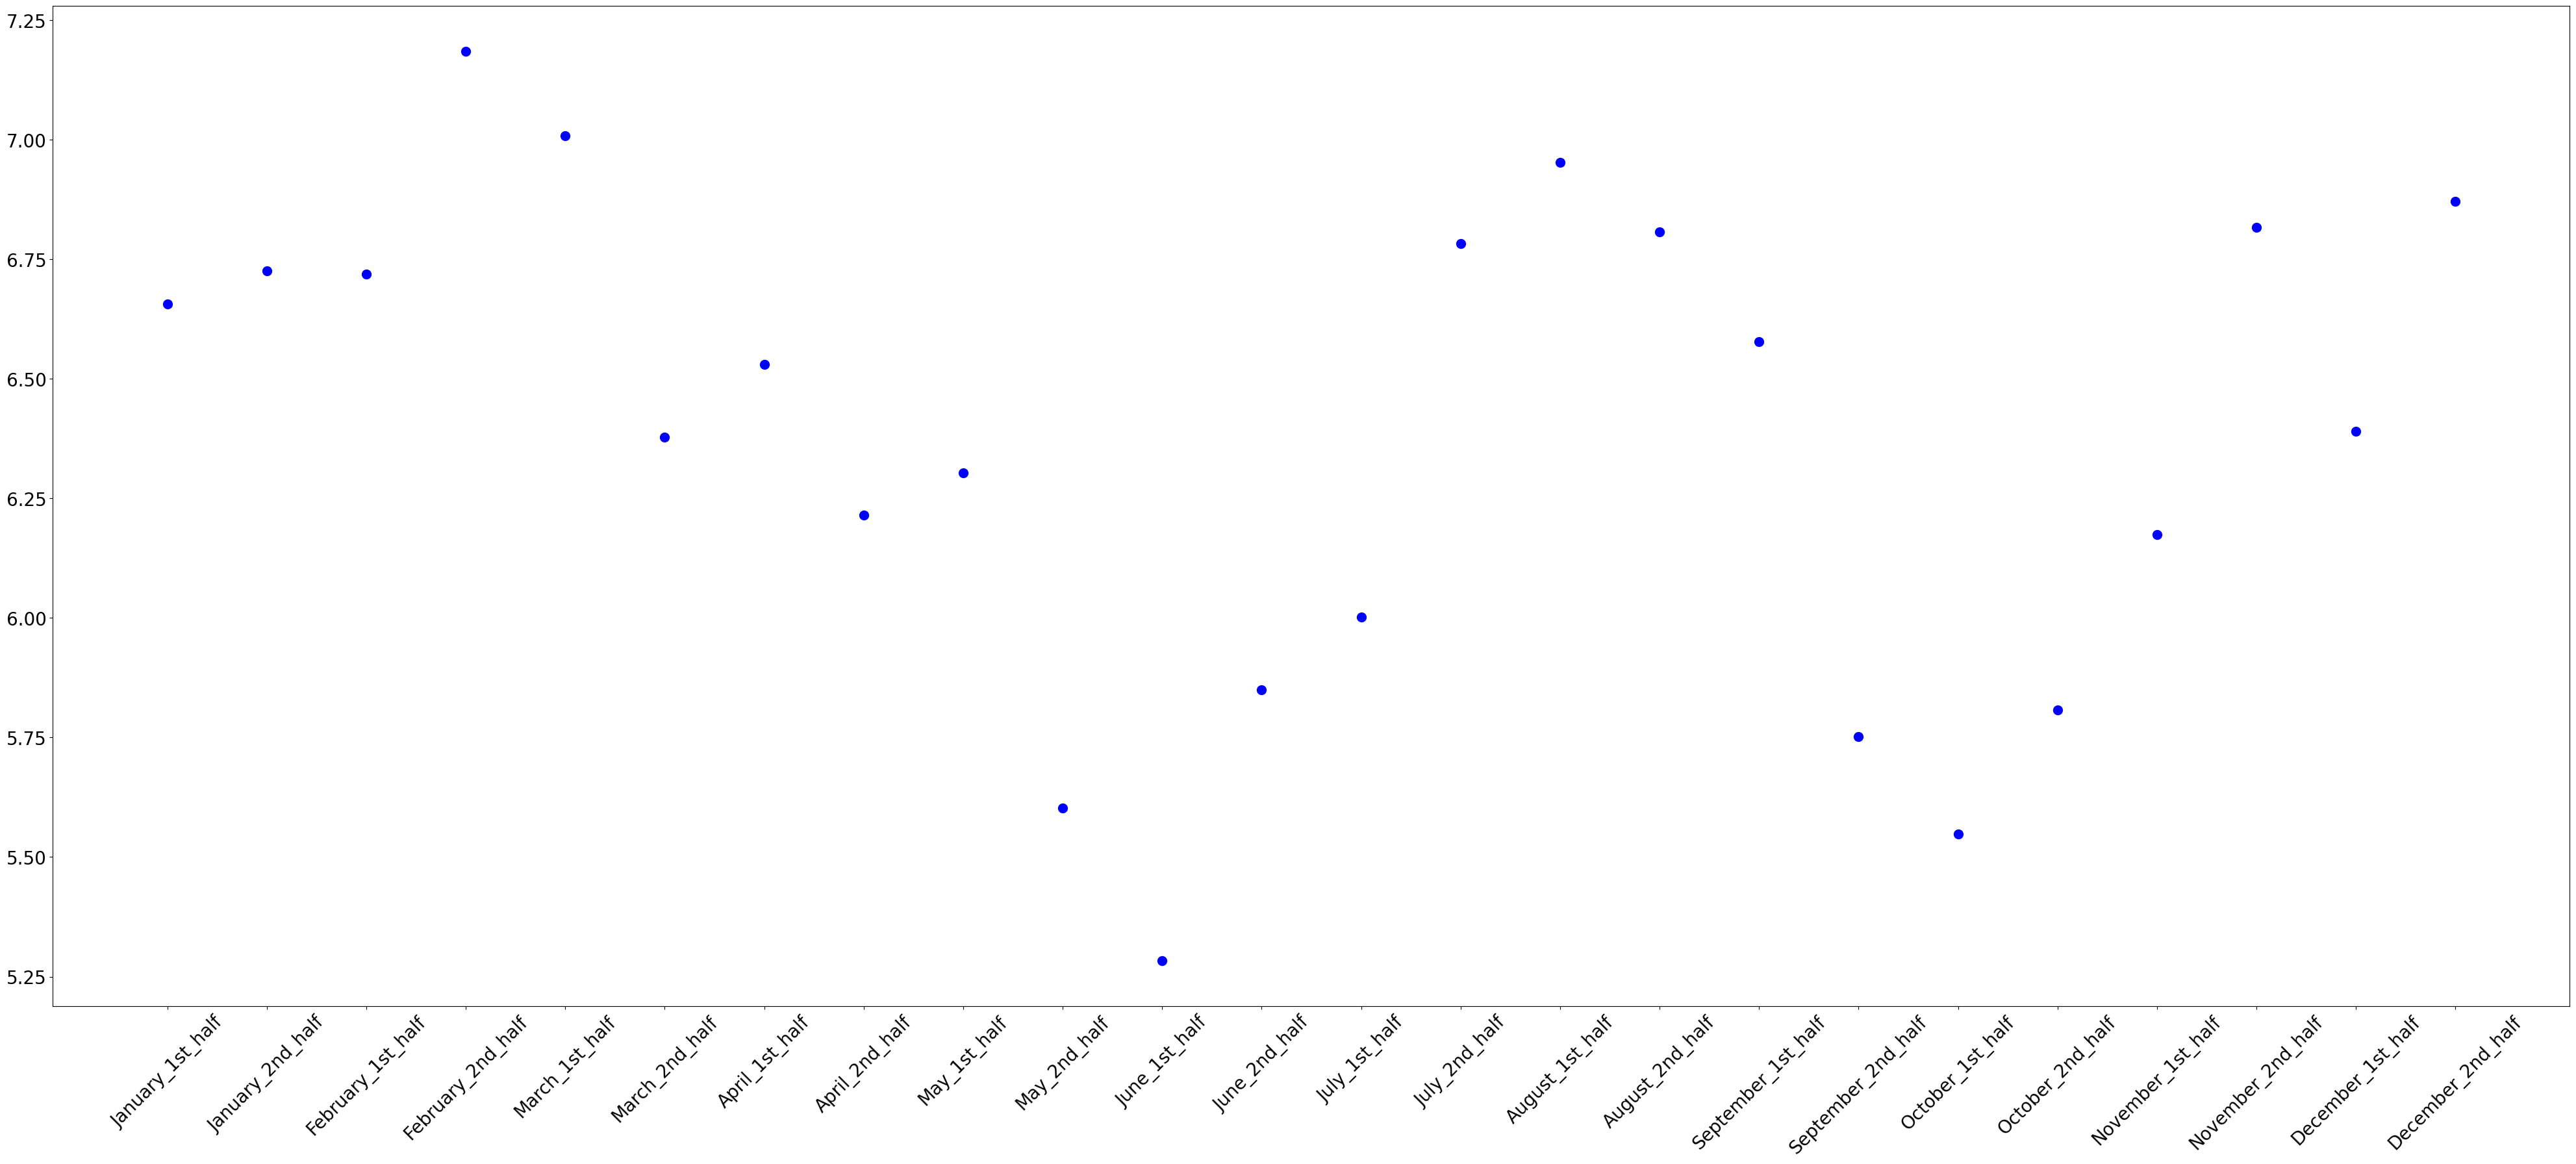

In [184]:
plt.figure(figsize=(50, 20))
plt.scatter(df_5y.index,df_5y['avg_traj_windspeed','mean'],color='blue',s=100)
plt.xticks(rotation=45,fontsize=20);
plt.yticks(fontsize=20);

In [185]:
df_5y.index = df_5y.index.str.replace('January_1st_half', '01-01-2023')
df_5y.index = df_5y.index.str.replace('January_2nd_half', '01-16-2023')
df_5y.index = df_5y.index.str.replace('February_1st_half', '02-01-2023')
df_5y.index = df_5y.index.str.replace('February_2nd_half', '02-16-2023')
df_5y.index = df_5y.index.str.replace('March_1st_half', '03-01-2023')
df_5y.index = df_5y.index.str.replace('March_2nd_half', '03-16-2023')
df_5y.index = df_5y.index.str.replace('April_1st_half', '04-01-2023')
df_5y.index = df_5y.index.str.replace('April_2nd_half', '04-16-2023')
df_5y.index = df_5y.index.str.replace('May_1st_half', '05-01-2023')
df_5y.index = df_5y.index.str.replace('May_2nd_half', '05-16-2023')
df_5y.index = df_5y.index.str.replace('June_1st_half', '06-01-2023')
df_5y.index = df_5y.index.str.replace('June_2nd_half', '06-16-2023')
df_5y.index = df_5y.index.str.replace('July_1st_half', '07-01-2023')
df_5y.index = df_5y.index.str.replace('July_2nd_half', '08-16-2023')
df_5y.index = df_5y.index.str.replace('August_1st_half', '08-01-2023')
df_5y.index = df_5y.index.str.replace('August_2nd_half', '08-16-2023')
df_5y.index = df_5y.index.str.replace('September_1st_half', '09-01-2023')
df_5y.index = df_5y.index.str.replace('September_2nd_half', '09-16-2023')
df_5y.index = df_5y.index.str.replace('October_1st_half', '10-01-2023')
df_5y.index = df_5y.index.str.replace('October_2nd_half', '10-16-2023')
df_5y.index = df_5y.index.str.replace('November_1st_half', '11-01-2023')
df_5y.index = df_5y.index.str.replace('November_2nd_half', '11-16-2023')
df_5y.index = df_5y.index.str.replace('December_1st_half', '12-01-2023')
df_5y.index = df_5y.index.str.replace('December_2nd_half', '12-16-2023')

In [186]:
df_5y.index = pd.to_datetime(df_5y.index, format='%m-%d-%Y')
df_5y['avg_traj_winddir_rad','mean'] = np.deg2rad(df_5y['avg_traj_winddir','mean'])
df_5y['traj_time','scaled']= df_5y['traj_time','mean'] / df_5y['traj_time','mean'].max() * 100

In [187]:
df_5y

avg_traj_windspeed                      avg_traj_winddir  \
                         mean       min        max             mean   
semi_month                                                            
2023-01-01           6.657265  5.429661   8.394290       203.274138   
2023-01-16           6.726034  4.574227  10.152929       205.523644   
2023-02-01           6.719270  4.874481   8.676907       216.735805   
2023-02-16           7.184980  4.566104   8.369250       217.242527   
2023-03-01           7.008045  3.751347   8.613431       223.820390   
2023-03-16           6.378521  4.939658   8.142455       228.065288   
2023-04-01           6.529757  4.788014   7.784411       224.493074   
2023-04-16           6.215666  4.484847   7.400849       220.218823   
2023-05-01           6.303733  4.305133   7.024717       219.562111   
2023-05-16           5.602260  3.966113   7.128746       203.591847   
2023-06-01           5.283041  4.128072   6.703415       193.979456   
2023-06-16           5.850268  4.832892   7.958075       176.374587   
2023-07-01           6.001732  4.430607   7.029062       131.455708   
2023-08-16           6.783519  4.943092   8.104579       113.844270   
2023-08-01           6.952686  5.607335   8.304153       107.382766   
2023-08-16           6.806910  5.082403   7.982105        85.513002   
2023-09-01           6.577384  4.350283   7.364998       101.780723   
2023-09-16           5.752653  4.677526   6.487137       128.078329   
2023-10-01           5.548065  4.351452   6.853787       148.414721   
2023-10-16           5.808287  3.559866   7.379266       172.946586   
2023-11-01           6.174307  5.024385   7.214995       179.704121   
2023-11-16           6.817713  5.533573   8.130514       180.950500   
2023-12-01           6.390558  5.016630   7.803238       194.588124   
2023-12-16           6.871736  5.029889   9.729515       196.271517   

                                    traj_time                       month      \
                   min         max       mean        min        max  mean min   
semi_month                                                                      
2023-01-01  184.068606  221.781655  30.379308  28.224019  32.363542   1.0   1   
2023-01-16  185.200923  235.072320  30.105620  28.224019  31.610901   1.0   1   
2023-02-01  185.778176  249.152811  30.276675  27.471379  33.492503   2.0   2   
2023-02-16  197.755219  242.456914  30.189247  28.976660  33.116182   2.0   2   
2023-03-01  205.868802  241.844223  29.660878  27.847699  33.868823   3.0   3   
2023-03-16  208.148233  253.928776  30.105620  28.976660  31.610901   3.0   3   
2023-04-01  200.648425  246.784424  31.029315  28.976660  33.492503   4.0   4   
2023-04-16  198.089130  242.395152  31.097737  28.976660  33.116182   4.0   4   
2023-05-01  190.404336  256.536847  31.836693  29.729300  33.868823   5.0   5   
2023-05-16  167.375588  277.731110  33.084822  31.234581  34.997784   5.0   5   
2023-06-01  166.606926  229.619219  34.860940  32.363542  37.255705   6.0   6   
2023-06-16  111.732399  215.825299  35.900952  33.868823  40.266267   6.0   6   
2023-07-01   51.568801  187.997870  37.666236  34.621463  41.395228   7.0   7   
2023-08-16   87.662754  190.910164  40.334689  35.750424  44.029470   7.0   7   
2023-08-01   85.994180  151.296459  40.882064  36.879385  44.782110   8.0   8   
2023-08-16   48.016686  109.959941  41.614748  36.503065  44.405790   8.0   8   
2023-09-01   78.781490  131.382314  39.664155  37.255705  43.653149   9.0   9   
2023-09-16   95.053479  156.450331  37.939924  33.492503  42.524189   9.0   9   
2023-10-01   76.643356  219.198889  37.255705  32.363542  41.018908  10.0  10   
2023-10-16   96.076789  262.758302  34.860940  32.739862  36.503065  10.0  10   
2023-11-01  158.961790  198.350918  32.910917  31.234581  34.997784  11.0  11   
2023-11-16  127.964176  206.178613  32.363542  28.600339  37.255705  11.0  11   
2023-12-01  179.020501  216.509225  31.799061  29.352980  33.868823 

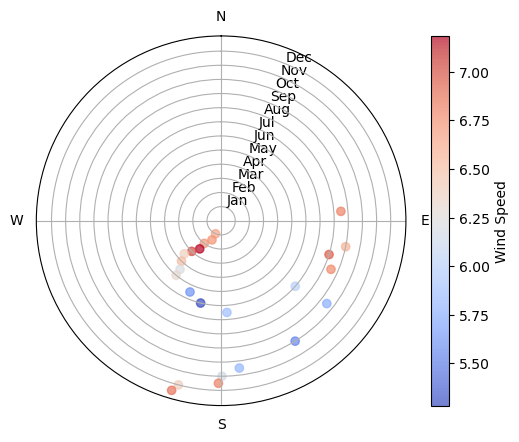

In [188]:
ax = plt.subplot(111, polar=True)

scatter=ax.scatter(df_5y['avg_traj_winddir_rad','mean'], df_5y.index.month+(df_5y.index.day > 15)*0.5, c=df_5y['avg_traj_windspeed','mean'],
    cmap='coolwarm',  # Colormap for the color values
    alpha=0.7)

ax.set_theta_zero_location("N")

ax.set_theta_direction(-1)

ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
ax.set_xticklabels(['N', 'E', 'S', 'W'])
ax.set_yticks(range(1,13))
ax.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
cbar = plt.colorbar(scatter)
cbar.set_label('Wind Speed')
plt.show()


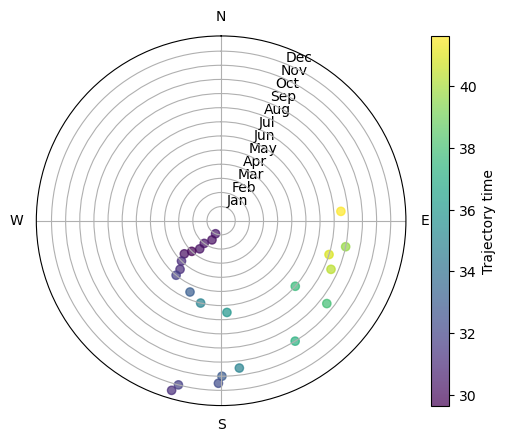

In [189]:

ax = plt.subplot(111, polar=True)

scatter=ax.scatter(df_5y['avg_traj_winddir_rad','mean'], df_5y.index.month+(df_5y.index.day > 15)*0.5, c=df_5y['traj_time','mean'],
    cmap='viridis',  # Colormap for the color values
    alpha=0.7)

ax.set_theta_zero_location("N")

ax.set_theta_direction(-1)

ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
ax.set_xticklabels(['N', 'E', 'S', 'W'])
ax.set_yticks(range(1,13))
ax.set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
cbar = plt.colorbar(scatter)
cbar.set_label('Trajectory time')
plt.show()

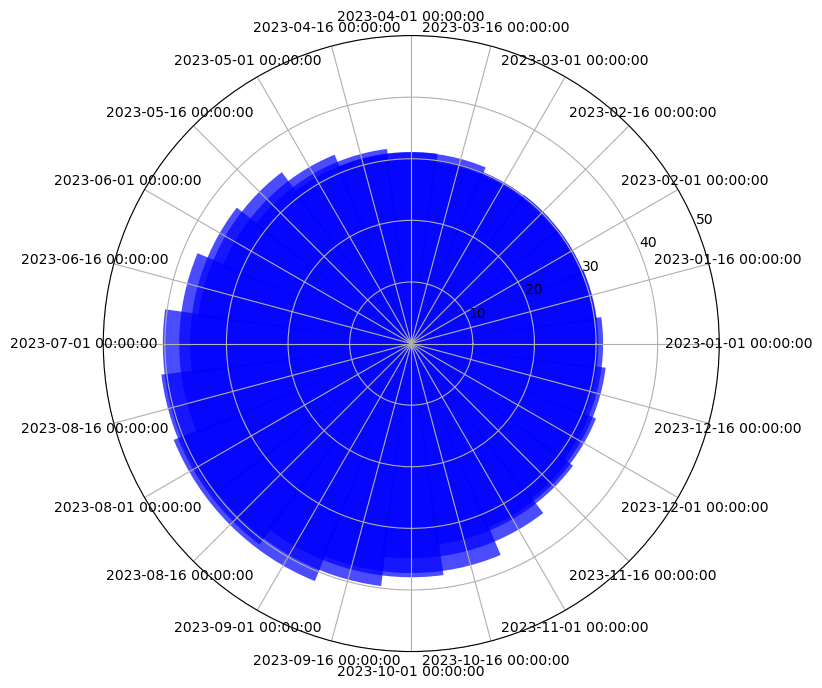

In [190]:
N = len(df_5y.index)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.bar(angles,  df_5y['traj_time']['mean'], color='blue', alpha=0.7)

ax.set_xticks(angles)
ax.set_xticklabels(df_5y.index)

ax.set_ylim(0, 50)

plt.show()

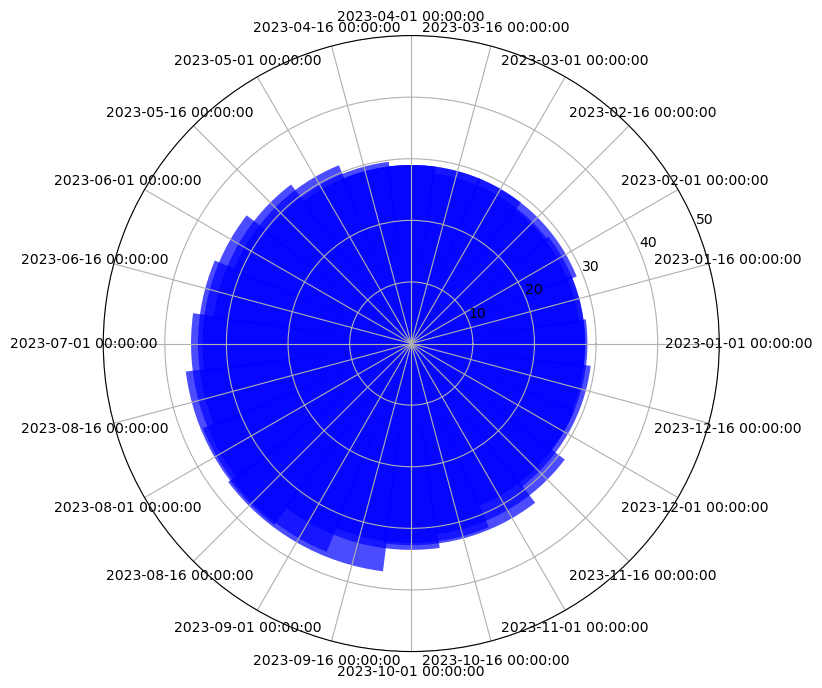

In [191]:
N = len(df_5y.index)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.bar(angles,  df_5y['traj_time']['min'], color='blue', alpha=0.7)

ax.set_xticks(angles)
ax.set_xticklabels(df_5y.index)

ax.set_ylim(0, 50)

plt.show()

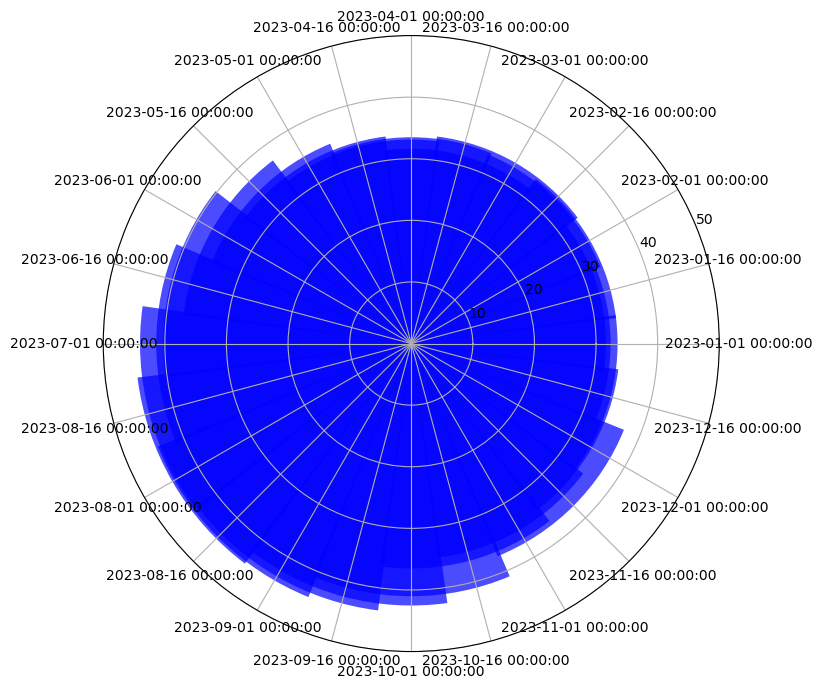

In [192]:
N = len(df_5y.index)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.bar(angles,  df_5y['traj_time']['max'], color='blue', alpha=0.7)

ax.set_xticks(angles)
ax.set_xticklabels(df_5y.index)

ax.set_ylim(0, 50)

plt.show()

# Statistical analysis over each year : seasonality

## 2022

In [193]:
dates_2022=[date[4:8] for date in dates_str_2022]
dates_2022_best=[date[4:8] for date in list(data_best_2022.keys())]
dates_2022_worst=[date[4:8] for date in list(data_worst_2022.keys())]

In [194]:
#get average wind conditions and travel time over 2022
avg_windspeed_2022,avg_winddir_2022,avg_windspeed_best_2022,avg_winddir_best_2022,avg_windspeed_worst_2022,avg_winddir_worst_2022=get_avg_wind_cond(windspeed_2022,winddir_2022,windspeed_best_2022,winddir_best_2022,windspeed_worst_2022,winddir_worst_2022)
avg_traj_time_2022,avg_traj_time_2022_best,avg_traj_time_2022_worst=get_avg_traj_time(traj_time_2022,traj_time_best_2022,traj_time_worst_2022)


print("Average wind speed 2022:",avg_windspeed_2022)
print("Average wind direction 2022:",avg_winddir_2022)
print("Average trajectory time 2022:",avg_traj_time_2022,'\n')

print("Average wind speed of 25% shortest traj_opt 2022:",avg_windspeed_best_2022)
print("Average wind direction of 25% shortest traj_opt 2022::",avg_winddir_best_2022)
print("Average trajectory time of 25% shortest traj_opt 2022:",avg_traj_time_2022_best,'\n')

print("Average wind speed of 25% longest traj_opt 2022:",avg_windspeed_worst_2022)
print("Average wind direction of 25% longest traj_opt 2022:",avg_winddir_worst_2022)
print("Average trajectory time of 25% longest traj_opt 2022:",avg_traj_time_2022_worst,'\n')


Average wind speed 2022: 6.304348980764484
Average wind direction 2022: 179.87296932625054
Average trajectory time 2022: 34.33922316008548 

Average wind speed of 25% shortest traj_opt 2022: 7.00503411970923
Average wind direction of 25% shortest traj_opt 2022:: 208.90619692804668
Average trajectory time of 25% shortest traj_opt 2022: 29.845090898269227 

Average wind speed of 25% longest traj_opt 2022: 6.648327764653097
Average wind direction of 25% longest traj_opt 2022: 112.7733286447401
Average trajectory time of 25% longest traj_opt 2022: 40.46890114040598 



<font color = "purple"> Pour l'année 2022 : Nous avons calculé la durée moyenne des trajets sur l'année (34,3h), puis sur les temps de trajet les plus courts (29,8h) et sur les temps de trajets les plus long (40,5 heures). Ces données sont cohérentes avec la figure : HISTOGRAMME SUR 5 ANS.
    
 Nous avons calculé la vitesse moyenne de vent sur l'année (6.30), puis sur les temps de trajet les plus courts (7.00) et sur les temps de trajets les plus long (6.65). Grâce à ces valeurs, on peut voir que la moyenne de vitesse de vent entre les trajets avec les temps les plus courts et ceux avec les temps les plus longs n'est pas si différénte. On peut donc penser que ce n'est pas ce facteur qui va être déterminent pour savoir si le temps du trajet sera court ou long.
    
Analysons maintenant la direction du vent : la direction moyenne de vent sur l'année est de 179 : Sud, sur les temps de trajet les plus courts de 208 : Sud Ouest et sur les temps de trajets les plus long, elle est de 112 : Sud Est. Ainsi, une direction de vent "favorable" pour minimiser le temps de trajet est la directuion Sur- Ouest ce qui nous paraît cohérent puisque c'est la direction correspondant au trajet Dakar-Natal. 

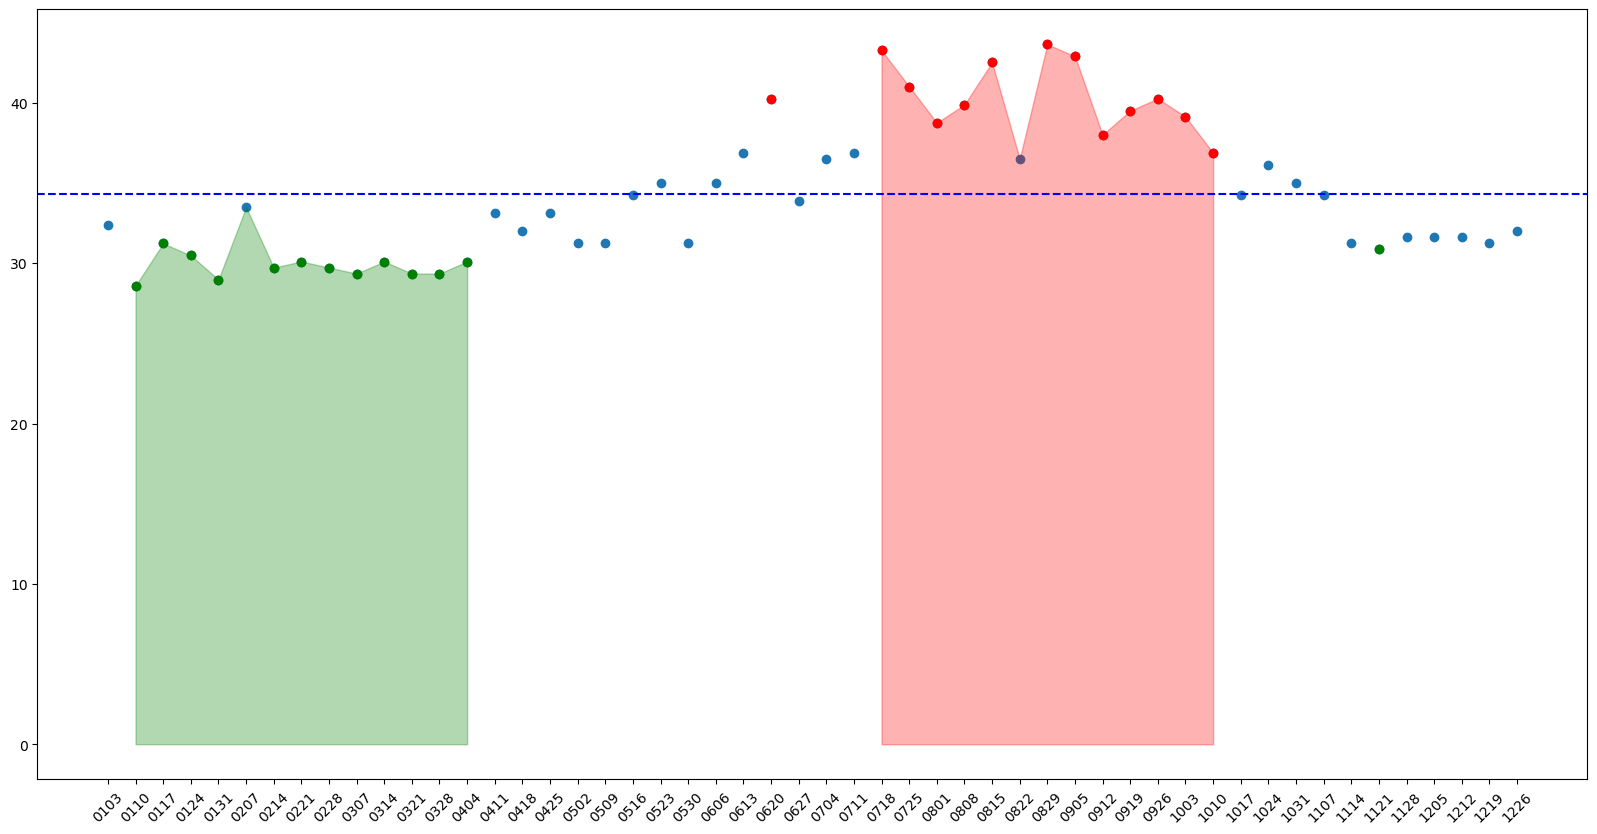

In [195]:

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_traj_time_2022, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2022,traj_time_2022)
plt.scatter(dates_2022_best,traj_time_best_2022,color='green')
plt.scatter(dates_2022_worst,traj_time_worst_2022,color='red')

#best period(s)
#plt.axvline(x='0613', color='green', linestyle=':')
#plt.axvline(x='0926', color='green', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('0110'):dates_2022.index('0404')+1], traj_time_2022[dates_2022.index('0110'):dates_2022.index('0404')+1],color='green', alpha=0.3)

#worst period(s)
#plt.axvline(x='1017', color='red', linestyle=':')
#plt.axvline(x='1107', color='red', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('0718'):dates_2022.index('1010')+1], traj_time_2022[dates_2022.index('0718'):dates_2022.index('1010')+1],color='red', alpha=0.3)




<font color = "purple"> Ici, nous avons représenté les temps de trajets en fonction des dates corresspondantes sur l'ensemble de l'année 2022. Le trait pointillé bleu correspond à la moyennes des temps de trajets sur l'année. Les points verts correspondent aux temps de trajets les plus courts, les rouges au plus longs et les bleus au temps moyens. Nous avons coloré en vert la zone correspondant aux trajets les plus courts et en rouge eclle correspondant aux trajets les plus longs. Ainsi, on observe que les temps de trajets les plus courts sont entre juin et début avril et ceux les plus longs sont entre juillet et septembre. Cela nous amène donc à supposer que durant la première période énoncée, le vent sera dans une direction favorable, c'est-à-dire Sud-Ouest et au contraire durant la seconde période, la direction de vent sera dans le sens opposé. Vérifions le : 

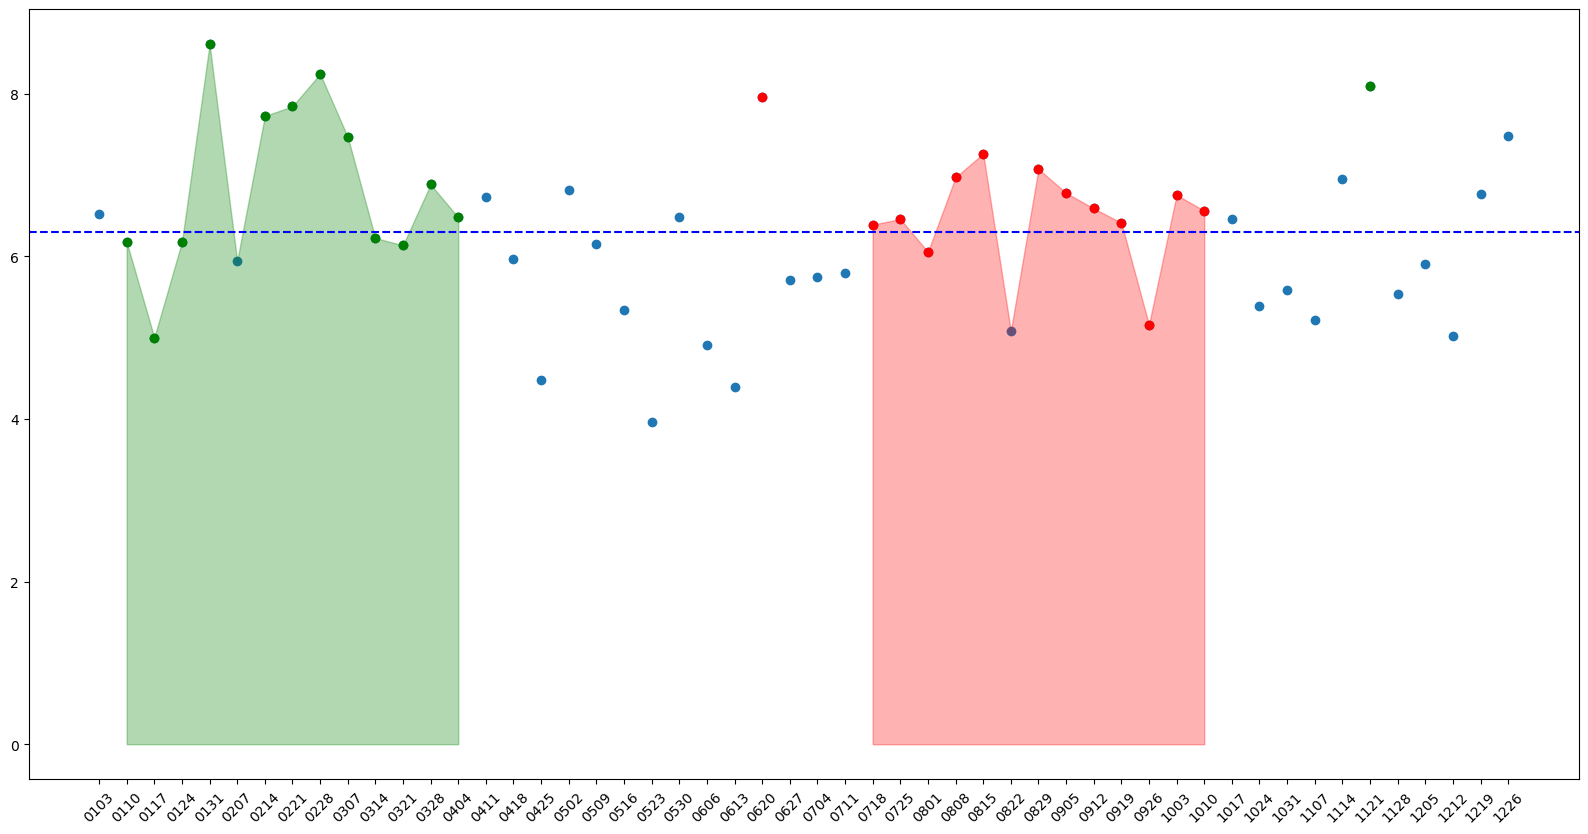

In [196]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_windspeed_2022, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2022,windspeed_2022)
plt.scatter(dates_2022_best,windspeed_best_2022,color='green')
plt.scatter(dates_2022_worst,windspeed_worst_2022,color='red')


#best period(s)
#plt.axvline(x='0613', color='green', linestyle=':')
#plt.axvline(x='0926', color='green', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('0110'):dates_2022.index('0404')+1], windspeed_2022[dates_2022.index('0110'):dates_2022.index('0404')+1],color='green', alpha=0.3)

#worst period(s)
#plt.axvline(x='1017', color='red', linestyle=':')
#plt.axvline(x='1107', color='red', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('0718'):dates_2022.index('1010')+1], windspeed_2022[dates_2022.index('0718'):dates_2022.index('1010')+1],color='red', alpha=0.3)



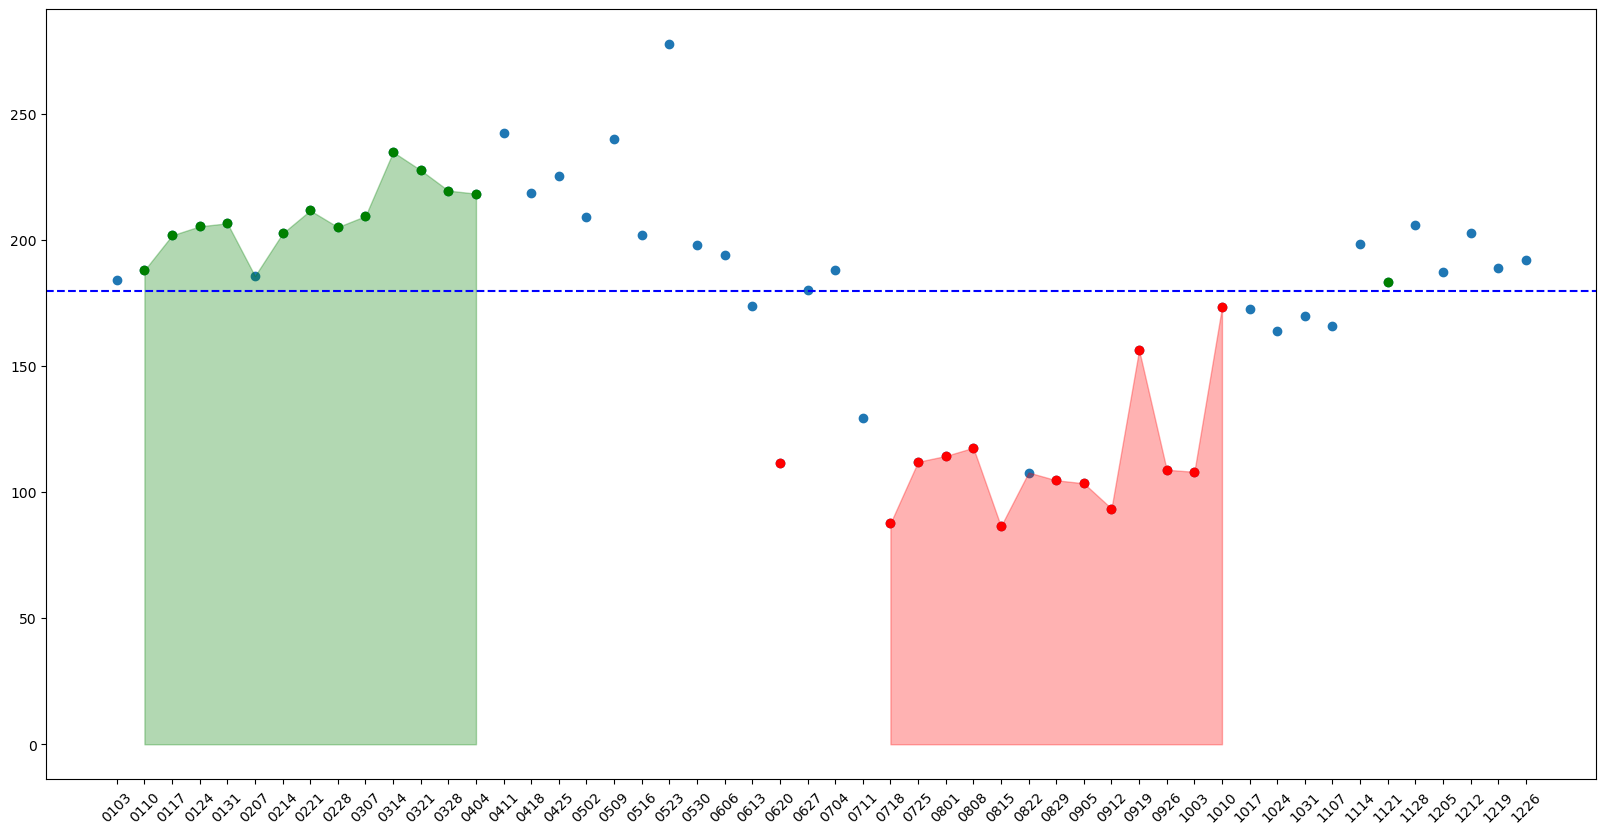

In [197]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_winddir_2022, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2022,winddir_2022)
plt.scatter(dates_2022_best,winddir_best_2022,color='green')
plt.scatter(dates_2022_worst,winddir_worst_2022,color='red')


#best period(s)
#plt.axvline(x='0613', color='green', linestyle=':')
#plt.axvline(x='0926', color='green', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('0110'):dates_2022.index('0404')+1], winddir_2022[dates_2022.index('0110'):dates_2022.index('0404')+1],color='green', alpha=0.3)

#worst period(s)
#plt.axvline(x='1017', color='red', linestyle=':')
#plt.axvline(x='1107', color='red', linestyle=':')
plt.fill_between(dates_2022[dates_2022.index('0718'):dates_2022.index('1010')+1], winddir_2022[dates_2022.index('0718'):dates_2022.index('1010')+1],color='red', alpha=0.3)



<font color = "purple"> Ici, nous avons représenté la même chose sauf que nous avons remplacé le temps de trajet par la direction de vent. Nous pouvons donc confirer notre analyse précédente : les trajectoires correspondants aux temps de trajets minimaux (points verts) correspondant à une direction de vent autour de 210 degrès : vent SO et ceux en rouge correspondent à une direction de 110 degrés : plutôt E.
    
    
    
Nous pouvons ici remarquer certaines anomalies que nous allons analyser. Par exemple prenons le cas des points bleus plus bas que certains points rouges (exemple le 22/08). Les points autour de 90 degrés correspondent à une direction plutôt est, ce qui est opposé à notre trajectoire don cela devrait être des points rouges. La pésence de ce point bleu peut donc paraître suspecte mais elle est facilement explicable si l'on regarde le graphique avec les vitesses. En effet, ce jour là, la vitesse de vent était assez faible 5m/s donc même si le vent n'allait pas dans le sens de la trahjectoire, son influence est faible car sa vitesse est faible. Ainsi, même si la vitesse ndu vent n'a pas le rôle majeur dans l'influence du temps de trajet, elle a tout de même une onfluence significative.

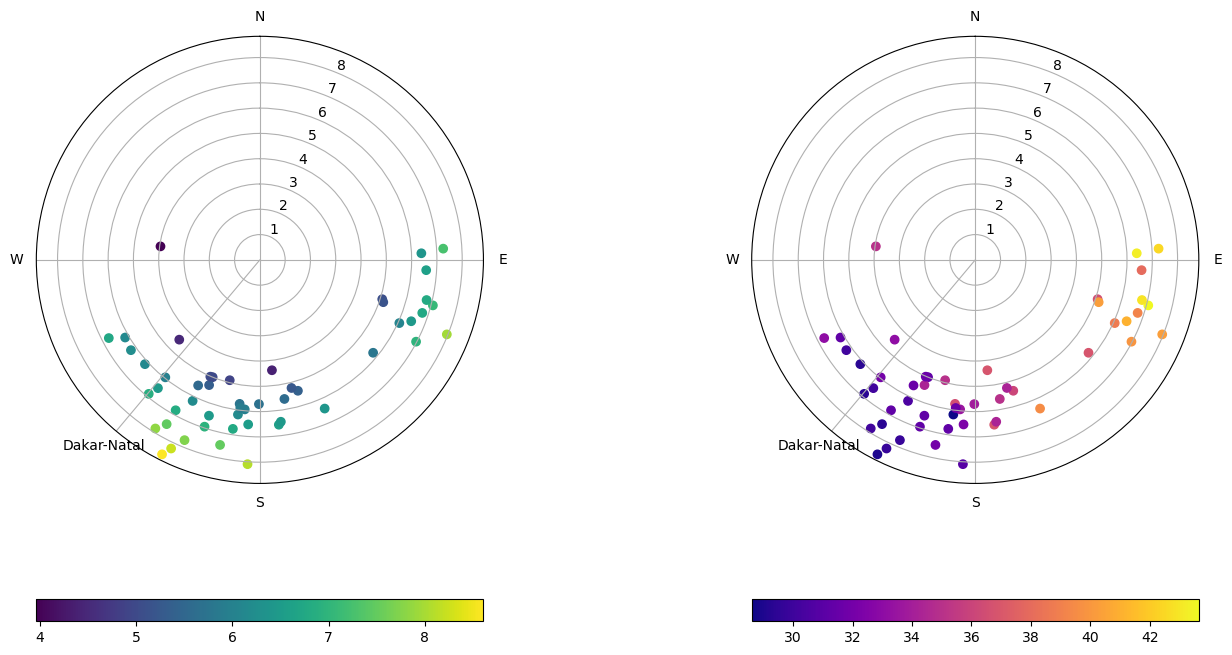

In [198]:
winddir_2022_rad=np.radians(winddir_2022)


#indices=np.arange(len(winddir_2022))
indices=windspeed_2022

fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)
    
c0 = axes[0].scatter(winddir_2022_rad, indices, c=windspeed_2022, cmap='viridis')
axes[0].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[0].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])

c1 = axes[1].scatter(winddir_2022_rad, indices, c=traj_time_2022, cmap='plasma')
axes[1].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])


fig.colorbar(c0, ax=axes[0], orientation='horizontal')
fig.colorbar(c1, ax=axes[1], orientation='horizontal') #redondant

plt.subplots_adjust(wspace=0.6)
plt.show()

<font color = "purple"> Mettre le graphique de dessous points verts et rouge avec lui.
    


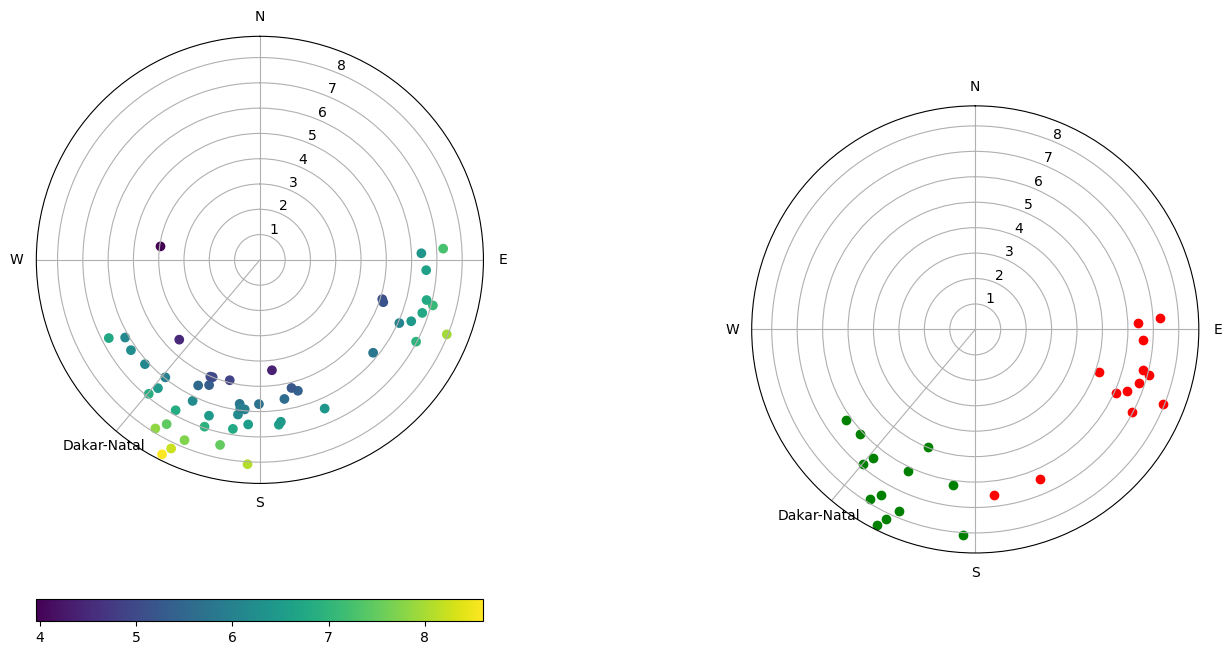

In [199]:
winddir_2022_rad=np.radians(winddir_2022)
winddir_best_2022_rad=np.radians(winddir_best_2022)
winddir_worst_2022_rad=np.radians(winddir_worst_2022)

#indices=np.arange(len(winddir_2022))
indices=windspeed_2022
indices_best=windspeed_best_2022
indices_worst=windspeed_worst_2022

fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)


c0 = axes[0].scatter(winddir_2022_rad, indices, c=windspeed_2022, cmap='viridis')
axes[0].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[0].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])

c1=axes[1].scatter(winddir_best_2022_rad, indices_best, color='green')
axes[1].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])

c2=axes[1].scatter(winddir_worst_2022_rad, indices_worst, color='red')
axes[1].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])




fig.colorbar(c0, ax=axes[0], orientation='horizontal')

plt.subplots_adjust(wspace=0.6)
plt.show()

Le premier graphique repésente la direction de vent en fonction de la vitesse et le second représente les 13 trajets les plus courts en verts et les 13 plus longs en rouge
    
Ces graphiques permettent de confirmer notre analyse : on voit bien que les points verts du second graphique correspondent au trajets ayant eu lieu lorsque la direction de vent est dans le sens de la trajectoire et avec les vitesses les plus élevées (points bleus clairs ou jaune). Au contraire, les points rouges du second graphique correespondant au trajets durant lesquels la direction de vent est Est avec une vitesse ausi assez forte : un vent fort pas dans la direction de la trajectoire.

In [200]:
the_best_data_2022, the_worst_data_2022=get_the_best_worst(u_v_time_opt_2022)

print("The shortest trajectory time data 2022:",the_best_data_2022)
print("The longest trajectory time data 2022:",the_worst_data_2022)

The shortest trajectory time data 2022: ('202201100000', [(array([-4.64933777, -4.64933777, -4.16471863, -4.16471863, -4.63542175,
       -4.42668152, -4.42668152, -3.75285339, -2.86955261, -2.86955261,
       -2.65470886, -2.65470886, -2.40080261, -1.81584167, -1.81584167,
       -1.73576355, -1.73576355, -2.36003113, -2.0912323 , -2.0912323 ,
       -3.38835144, -3.38835144, -3.42179871, -3.42179871, -4.56852722,
       -4.01799011, -4.01799011, -3.63420105, -3.63420105, -3.31632996,
       -3.31632996, -3.51335144, -3.51335144, -3.24601746, -3.25138855,
       -2.71720886, -2.54997253, -2.54997253, -2.14616394, -1.77677917,
       -2.03288269, -2.03288269, -2.20475769, -2.20475769, -2.23014832,
       -2.23014832, -2.23942566, -2.23942566, -2.02653503, -1.92472839,
       -1.94889832, -1.94889832, -2.01725769, -2.01725769, -2.01725769,
       -2.55290222, -2.55290222, -2.87638855, -2.87638855, -3.06169128,
       -3.27165222, -3.85661316, -3.85661316, -4.21110535, -4.70491028,
     

In [201]:
#corr between traj_time_2022 and windspeed_2022
#corr between traj_time_2022 and winddir_2022
#corr between avg_traj_time_2022 and avg_windspeed_2022
#corr between avg_traj_time_2022 and avg_winddir_2022
print(np.corrcoef(traj_time_2022,windspeed_2022)[0,1])
print(np.corrcoef(traj_time_2022,winddir_2022)[0,1])

print(np.corrcoef(traj_time_best_2022,windspeed_best_2022)[0,1])
#np.corrcoef(traj_time_2022,winddir_2022)[0,1]


-0.11610304030616865
-0.8356065240805784
-0.2784343471251181


## 2021

<font color = "purple"> Nous avons effectué la même analyse sur d'autres années : cohérent.

In [202]:
dates_2021=[date[4:8] for date in dates_str_2021]
dates_2021_best=[date[4:8] for date in list(data_best_2021.keys())]
dates_2021_worst=[date[4:8] for date in list(data_worst_2021.keys())]

In [203]:

avg_windspeed_2021,avg_winddir_2021,avg_windspeed_best_2021,avg_winddir_best_2021,avg_windspeed_worst_2021,avg_winddir_worst_2021=get_avg_wind_cond(windspeed_2021,winddir_2021,windspeed_best_2021,winddir_best_2021,windspeed_worst_2021,winddir_worst_2021)
avg_traj_time_2021,avg_traj_time_2021_best,avg_traj_time_2021_worst=get_avg_traj_time(traj_time_2021,traj_time_best_2021,traj_time_worst_2021)

print("Average wind speed 2021:",avg_windspeed_2021)
print("Average wind direction 2021:",avg_winddir_2021)
print("Average trajectory time 2021:",avg_traj_time_2021,'\n')

print("Average wind speed of 25% shortest traj_opt 2021:",avg_windspeed_best_2021)
print("Average wind direction of 25% shortest traj_opt 2021::",avg_winddir_best_2021)
print("Average trajectory time of 25% shortest traj_opt 2021:",avg_traj_time_2021_best,'\n')

print("Average wind speed of 25% longest traj_opt 2021:",avg_windspeed_worst_2021)
print("Average wind direction of 25% longest traj_opt 2021:",avg_winddir_worst_2021)
print("Average trajectory time of 25% longest traj_opt 2021:",avg_traj_time_2021_worst,'\n')

Average wind speed 2021: 6.3321720192225275
Average wind direction 2021: 182.7558206444864
Average trajectory time 2021: 33.803690491212606 

Average wind speed of 25% shortest traj_opt 2021: 7.604855540796333
Average wind direction of 25% shortest traj_opt 2021:: 208.60868445380405
Average trajectory time of 25% shortest traj_opt 2021: 29.64245691547009 

Average wind speed of 25% longest traj_opt 2021: 5.805353587092041
Average wind direction of 25% longest traj_opt 2021: 120.7577287510914
Average trajectory time of 25% longest traj_opt 2021: 39.13730639617521 



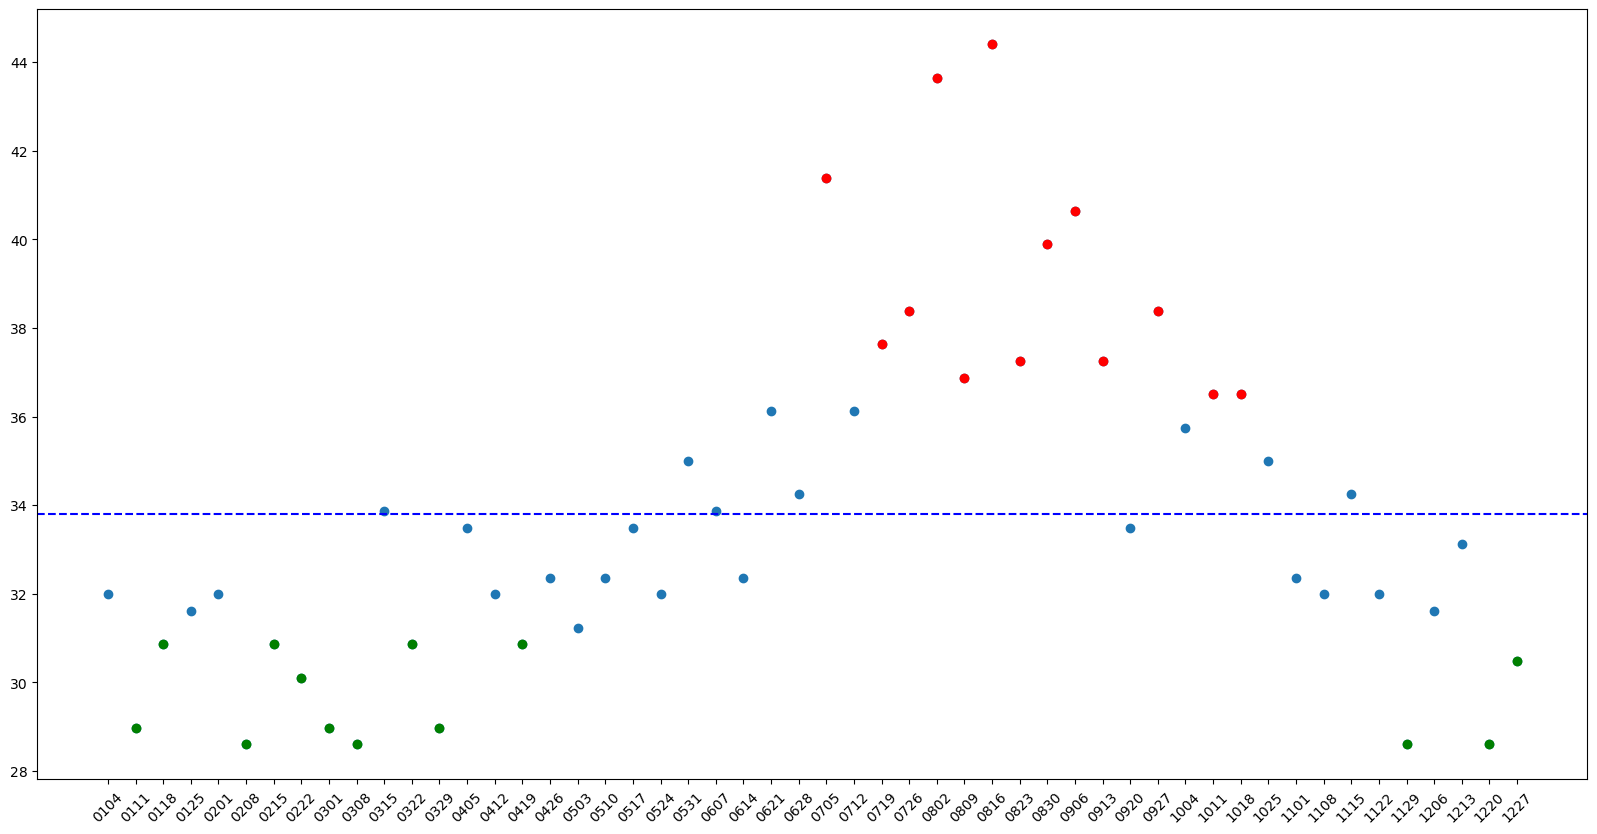

In [204]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_traj_time_2021, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2021,traj_time_2021)
plt.scatter(dates_2021_best,traj_time_best_2021,color='green')
plt.scatter(dates_2021_worst,traj_time_worst_2021,color='red')

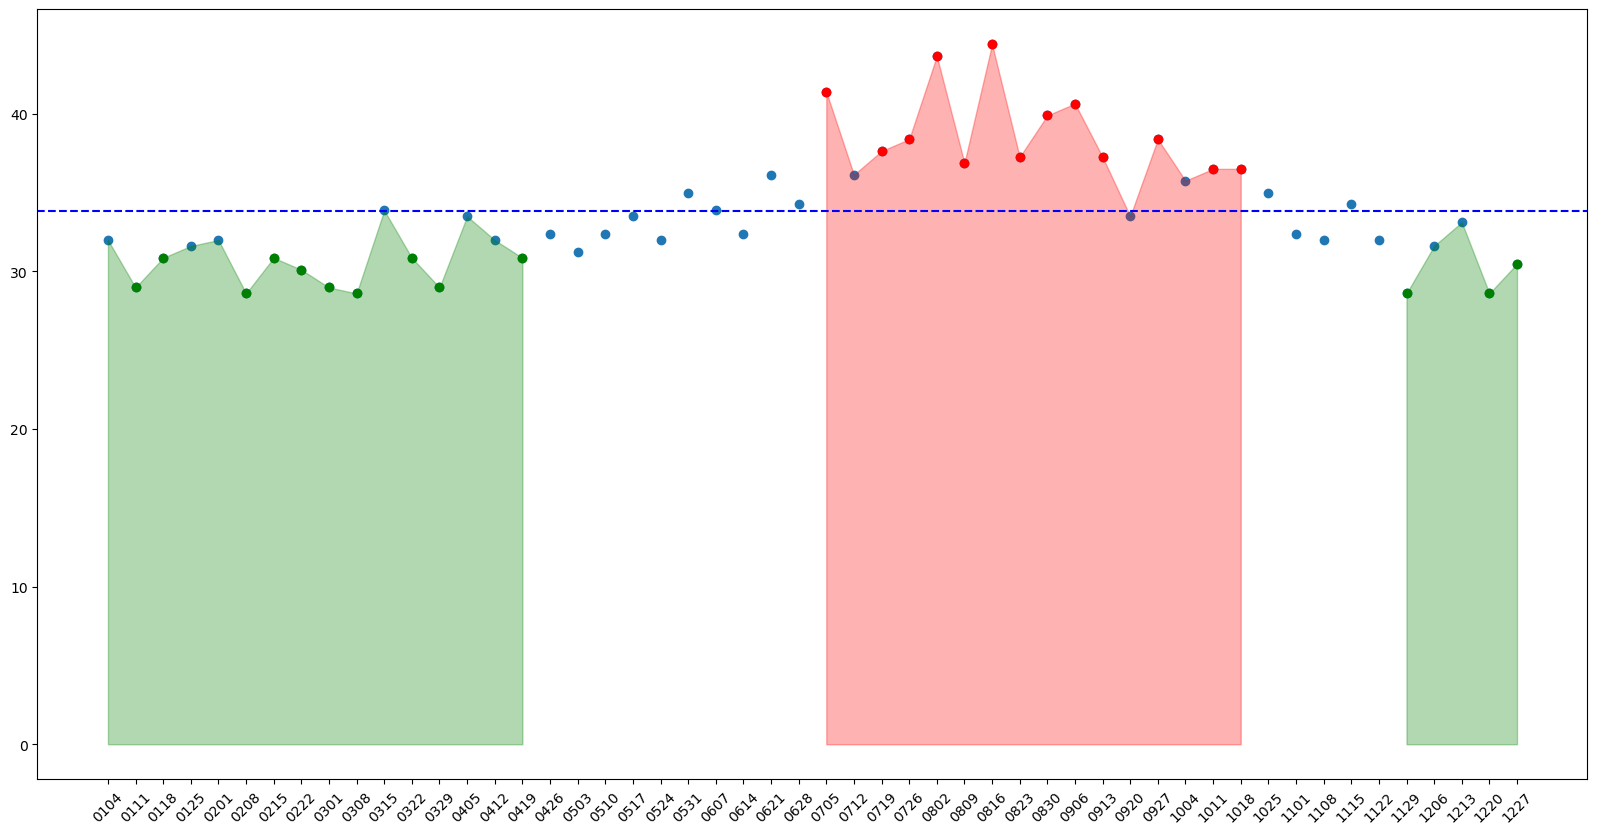

In [205]:

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_traj_time_2021, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2021,traj_time_2021)
plt.scatter(dates_2021_best,traj_time_best_2021,color='green')
plt.scatter(dates_2021_worst,traj_time_worst_2021,color='red')

#best period(s)
#plt.axvline(x='0613', color='green', linestyle=':')
#plt.axvline(x='0926', color='green', linestyle=':')
plt.fill_between(dates_2021[dates_2021.index('1129'):dates_2021.index('1227')+1], traj_time_2021[dates_2021.index('1129'):dates_2021.index('1227')+1],color='green', alpha=0.3)
plt.fill_between(dates_2021[dates_2021.index('0104'):dates_2021.index('0419')+1], traj_time_2021[dates_2021.index('0104'):dates_2021.index('0419')+1],color='green', alpha=0.3)

#worst period(s)
#plt.axvline(x='1017', color='red', linestyle=':')
#plt.axvline(x='1107', color='red', linestyle=':')
plt.fill_between(dates_2021[dates_2021.index('0705'):dates_2021.index('1018')+1], traj_time_2021[dates_2021.index('0705'):dates_2021.index('1018')+1],color='red', alpha=0.3)




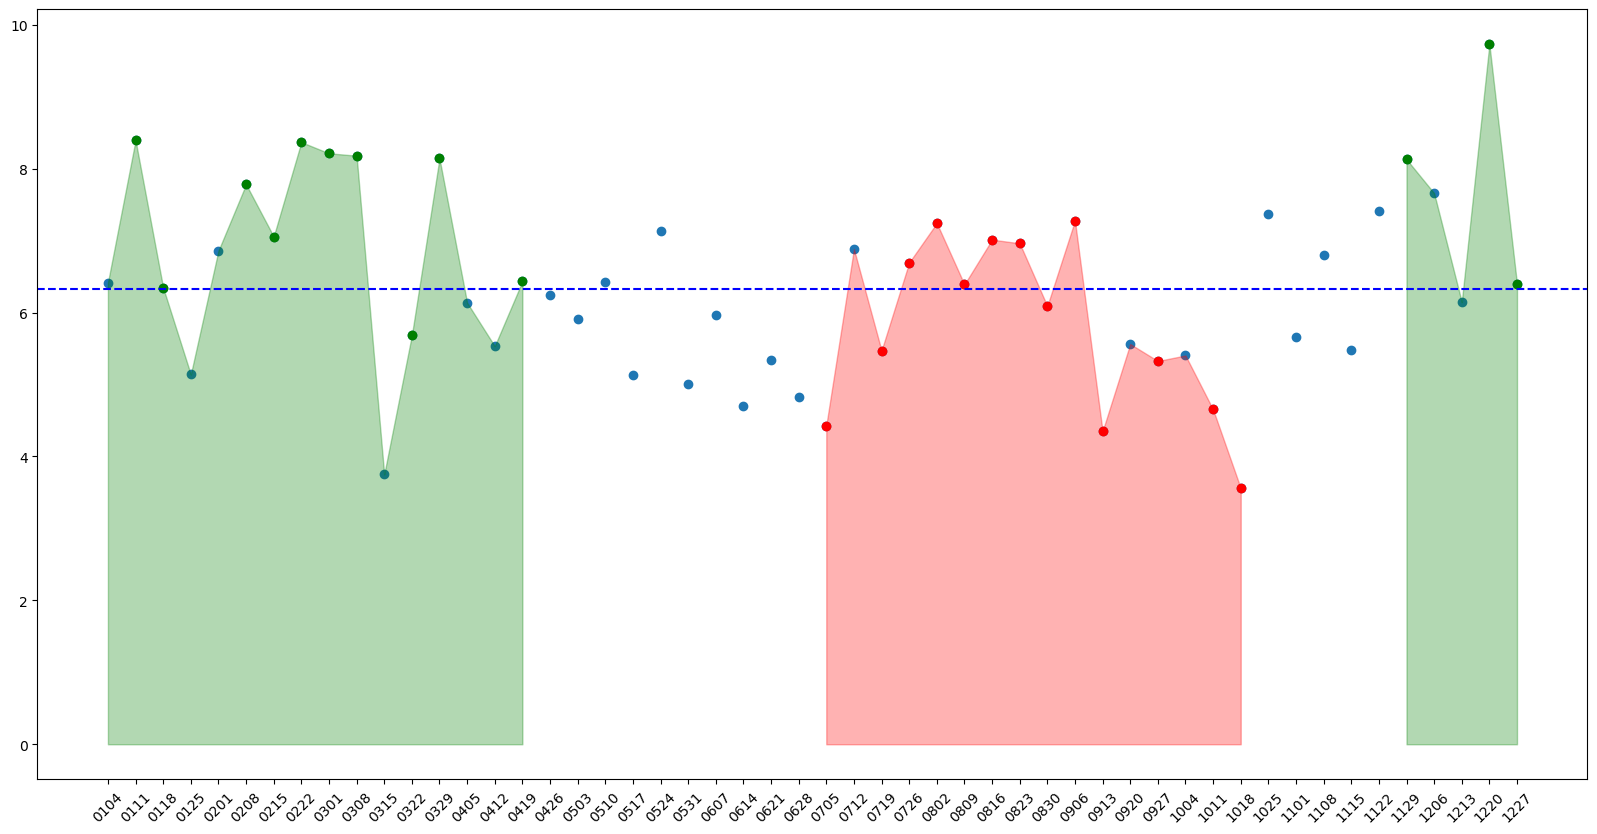

In [206]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_windspeed_2021, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2021,windspeed_2021)
plt.scatter(dates_2021_best,windspeed_best_2021,color='green')
plt.scatter(dates_2021_worst,windspeed_worst_2021,color='red')


plt.fill_between(dates_2021[dates_2021.index('1129'):dates_2021.index('1227')+1], windspeed_2021[dates_2021.index('1129'):dates_2021.index('1227')+1],color='green', alpha=0.3)
plt.fill_between(dates_2021[dates_2021.index('0104'):dates_2021.index('0419')+1], windspeed_2021[dates_2021.index('0104'):dates_2021.index('0419')+1],color='green', alpha=0.3)

#worst period(s)
#plt.axvline(x='1017', color='red', linestyle=':')
#plt.axvline(x='1107', color='red', linestyle=':')
plt.fill_between(dates_2021[dates_2021.index('0705'):dates_2021.index('1018')+1], windspeed_2021[dates_2021.index('0705'):dates_2021.index('1018')+1],color='red', alpha=0.3)





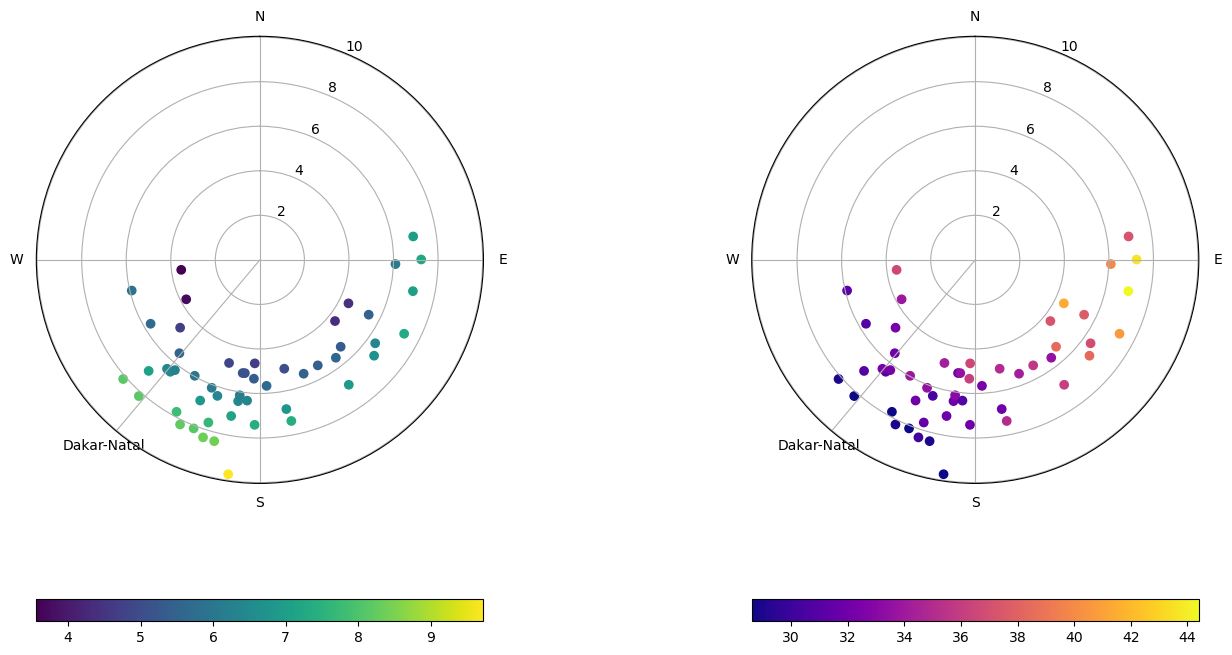

In [207]:
winddir_2021_rad=np.radians(winddir_2021)


#indices=np.arange(len(winddir_2022))
indices=windspeed_2021

fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)
    
c0 = axes[0].scatter(winddir_2021_rad, indices, c=windspeed_2021, cmap='viridis')
axes[0].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[0].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])

c1 = axes[1].scatter(winddir_2021_rad, indices, c=traj_time_2021, cmap='plasma')
axes[1].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])




fig.colorbar(c0, ax=axes[0], orientation='horizontal')
fig.colorbar(c1, ax=axes[1], orientation='horizontal') #redondant

plt.subplots_adjust(wspace=0.6)
plt.show()

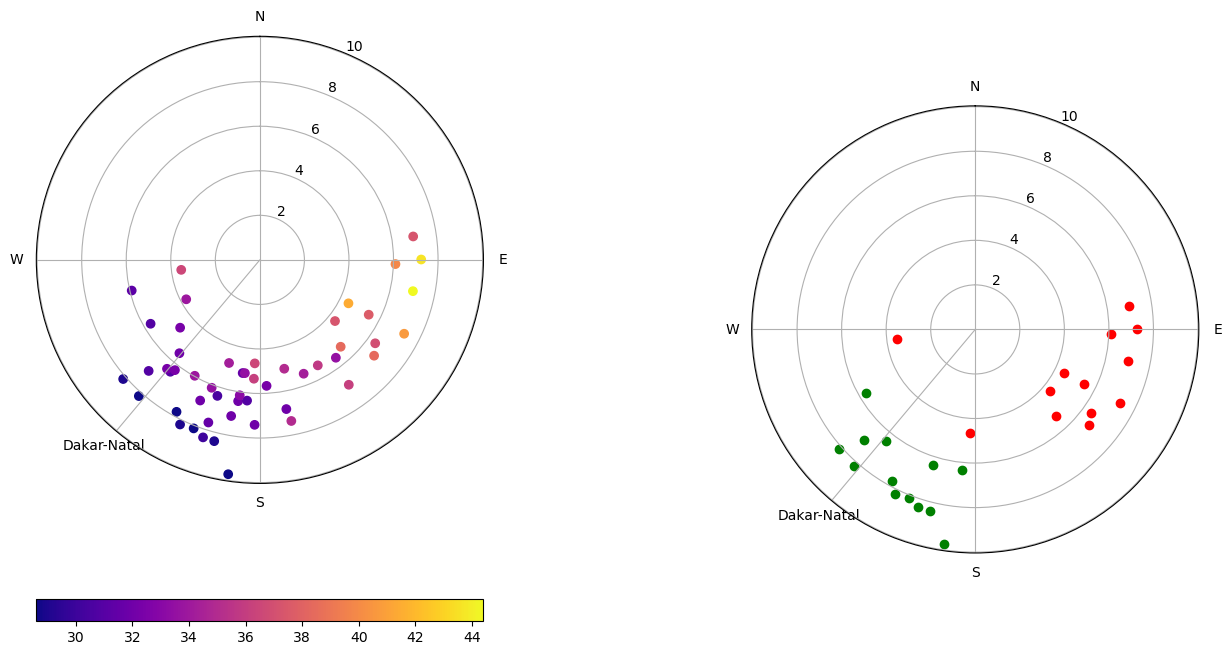

In [208]:
winddir_2021_rad=np.radians(winddir_2021)
winddir_best_2021_rad=np.radians(winddir_best_2021)
winddir_worst_2021_rad=np.radians(winddir_worst_2021)

#indices=np.arange(len(winddir_2022))
indices=windspeed_2021
indices_best=windspeed_best_2021
indices_worst=windspeed_worst_2021

fig, axes = plt.subplots(1, 2, figsize=(15, 10), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)


c0 = axes[0].scatter(winddir_2021_rad, indices, c=traj_time_2021, cmap='plasma')
axes[0].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[0].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])

c1=axes[1].scatter(winddir_best_2021_rad, indices_best, color='green')
axes[1].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])

c2=axes[1].scatter(winddir_worst_2021_rad, indices_worst, color='red')
axes[1].set_xticks(np.radians([0, 90, 180,220,  270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'Dakar-Natal','W'])




fig.colorbar(c0, ax=axes[0], orientation='horizontal')

plt.subplots_adjust(wspace=0.6)
plt.show()



In [209]:
the_best_data_2021, the_worst_data_2021=get_the_best_worst(u_v_time_opt_2021)

print("The shortest trajectory time data 2022:",the_best_data_2021)
print("The longest trajectory time data 2022:",the_worst_data_2021)

The shortest trajectory time data 2022: ('202102080000', [(array([-4.58804321, -4.58804321, -4.23062134, -4.23062134, -3.55044556,
       -4.60464478, -3.9960022 , -3.9960022 , -3.38833618, -4.96548462,
       -4.38516235, -4.38516235, -4.82070923, -4.82070923, -4.16934204,
       -3.63760376, -4.63711548, -4.26040649, -4.26040649, -3.95474243,
       -5.26870728, -4.90274048, -4.90274048, -5.32046509, -4.90151978,
       -4.90151978, -4.62197876, -5.22769165, -5.10977173, -5.10977173,
       -5.01797485, -5.51089478, -5.51089478, -5.65103149, -5.65103149,
       -5.71011353, -5.52481079, -5.52481079, -5.33853149, -5.49453735,
       -5.33535767, -5.33535767, -5.80459595, -5.80459595, -6.28652954,
       -6.28652954, -5.56729126, -5.56729126, -4.6222229 , -6.09170532,
       -5.27139282, -5.27139282, -5.60171509, -5.60171509, -7.42300415,
       -7.42300415, -6.96499634, -6.96499634, -6.53482056, -6.53482056,
       -7.39810181, -7.39810181, -7.63638306, -7.63638306, -5.25683594,
     

In [210]:
#corr between traj_time_2022 and windspeed_2022
#corr between traj_time_2022 and winddir_2022
#corr between avg_traj_time_2022 and avg_windspeed_2022
#corr between avg_traj_time_2022 and avg_winddir_2022
np.corrcoef(traj_time_2022,windspeed_2021)[0,1]
np.corrcoef(traj_time_2022,winddir_2021)[0,1]

np.corrcoef(traj_time_best_2021,windspeed_best_2021)[0,1]
#np.corrcoef(traj_time_2022,winddir_2022)[0,1]


-0.8244970423322387

## 2020

#on enleve les dates ou time_traj>>
dates_str_2022_new=list(np.copy(dates_str_2022))
dates_str_2022_new.remove('202203210000')
dates_str_2022_new.remove('202203280000')



In [211]:
dates_2020=[date[4:8] for date in dates_str_2020]
dates_2020_best=[date[4:8] for date in list(data_best_2020.keys())]
dates_2020_worst=[date[4:8] for date in list(data_worst_2020.keys())]

In [212]:
avg_windspeed_2020,avg_winddir_2020,avg_windspeed_best_2020,avg_winddir_best_2020,avg_windspeed_worst_2020,avg_winddir_worst_2020=get_avg_wind_cond(windspeed_2020,winddir_2020,windspeed_best_2020,winddir_best_2020,windspeed_worst_2020,winddir_worst_2020)
avg_traj_time_2020,avg_traj_time_2020_best,avg_traj_time_2020_worst=get_avg_traj_time(traj_time_2020,traj_time_best_2020,traj_time_worst_2020)


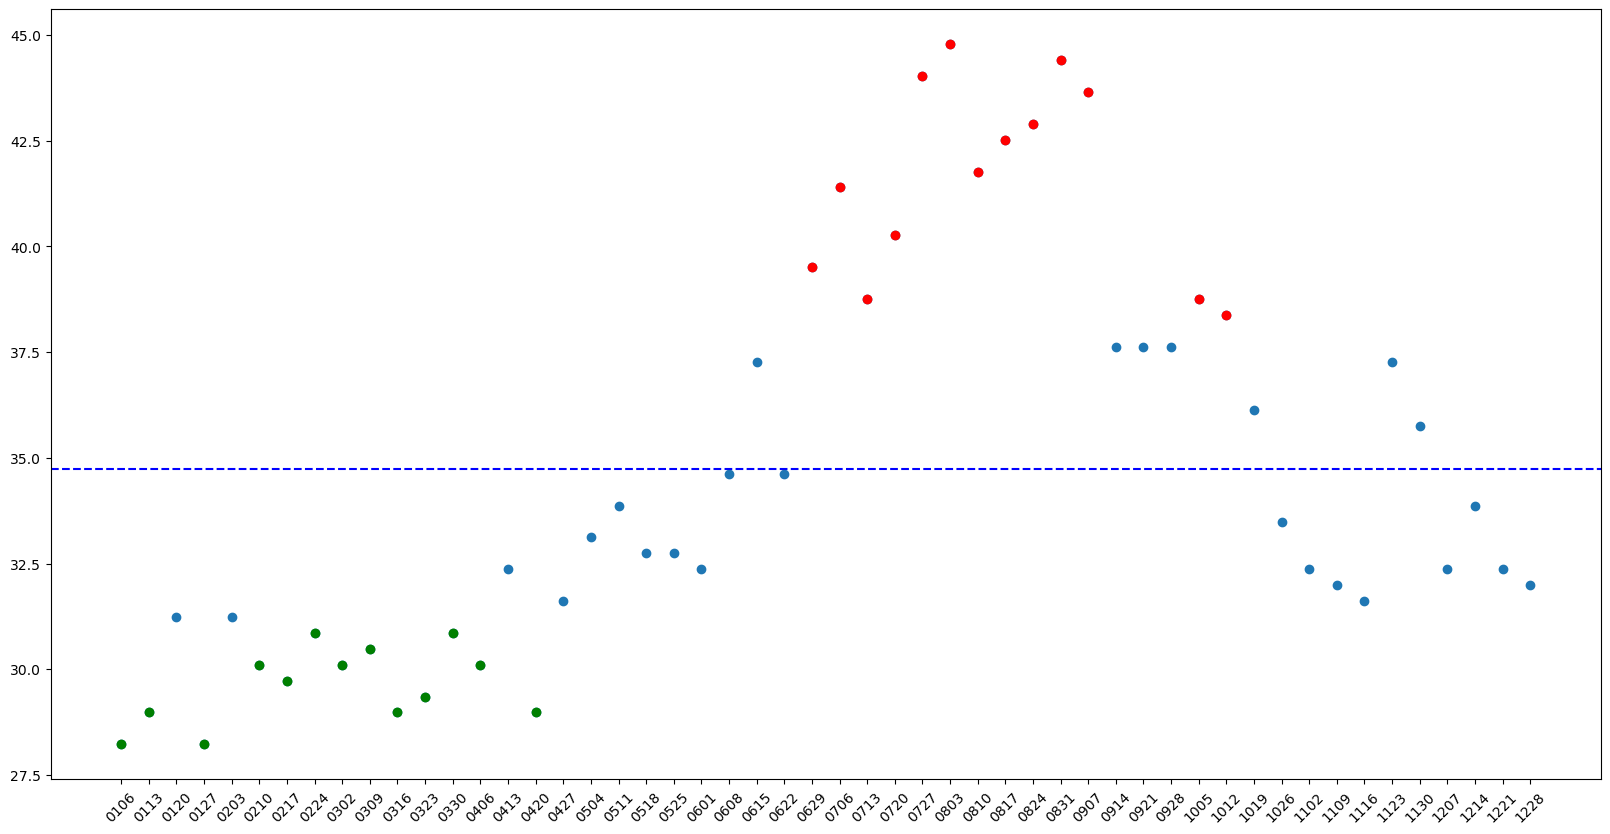

In [213]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_traj_time_2020, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2020,traj_time_2020)
plt.scatter(dates_2020_best,traj_time_best_2020,color='green')
plt.scatter(dates_2020_worst,traj_time_worst_2020,color='red')

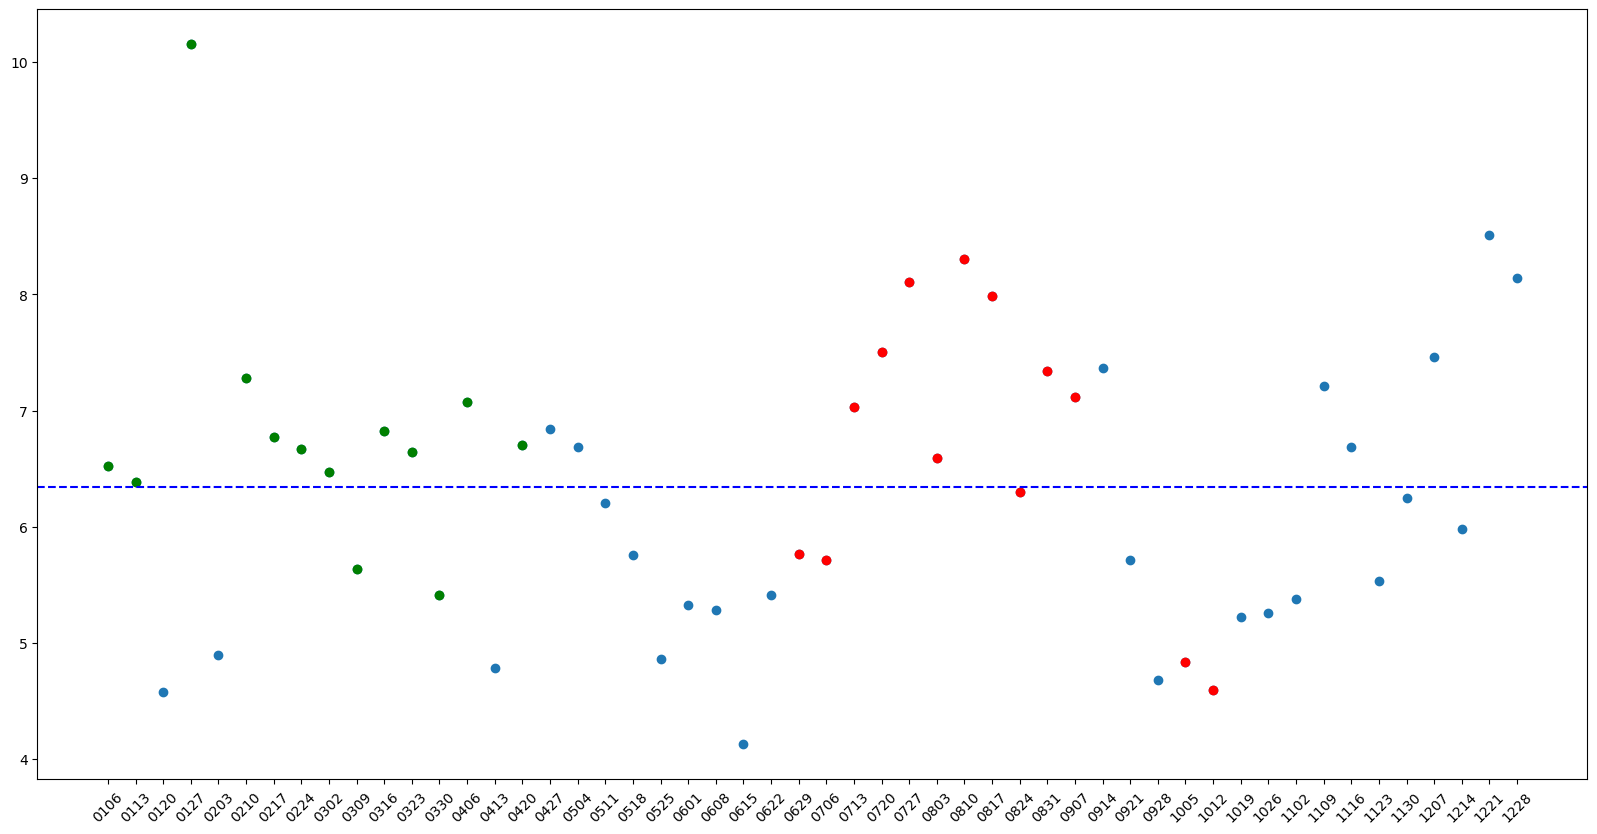

In [214]:

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_windspeed_2020, color='blue', linestyle='--')


plt.scatter(dates_2020,windspeed_2020)
plt.scatter(dates_2020_best,windspeed_best_2020,color='green')
plt.scatter(dates_2020_worst,windspeed_worst_2020,color='red')


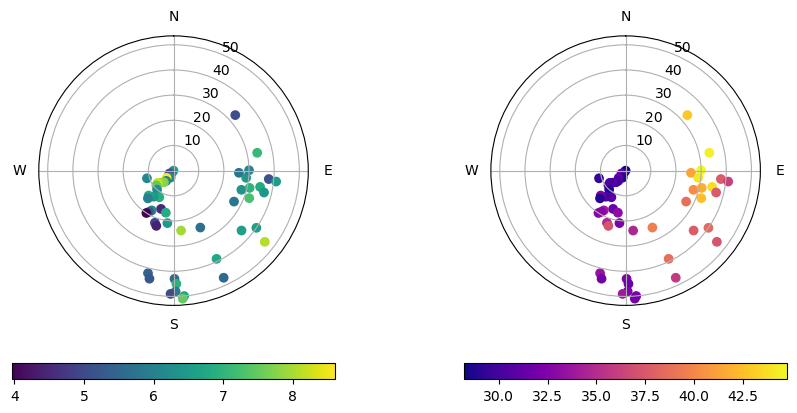

In [215]:
winddir_2020_rad=np.radians(winddir_2020)


indices=np.arange(len(winddir_2020))


fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)
    
c0 = axes[0].scatter(winddir_2020_rad, indices, c=windspeed_2022, cmap='viridis')
axes[0].set_xticks(np.radians([0, 90, 180, 270]))
axes[0].set_xticklabels(['N', 'E', 'S', 'W'])

c1 = axes[1].scatter(winddir_2020_rad, indices, c=traj_time_2020, cmap='plasma')
axes[1].set_xticks(np.radians([0, 90, 180, 270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'W'])

fig.colorbar(c0, ax=axes[0], orientation='horizontal')
fig.colorbar(c1, ax=axes[1], orientation='horizontal')

plt.subplots_adjust(wspace=0.4)
plt.show()

## 2019

In [216]:
dates_2019=[date[4:8] for date in dates_str_2019]
dates_2019_best=[date[4:8] for date in list(data_best_2019.keys())]
dates_2019_worst=[date[4:8] for date in list(data_worst_2019.keys())]

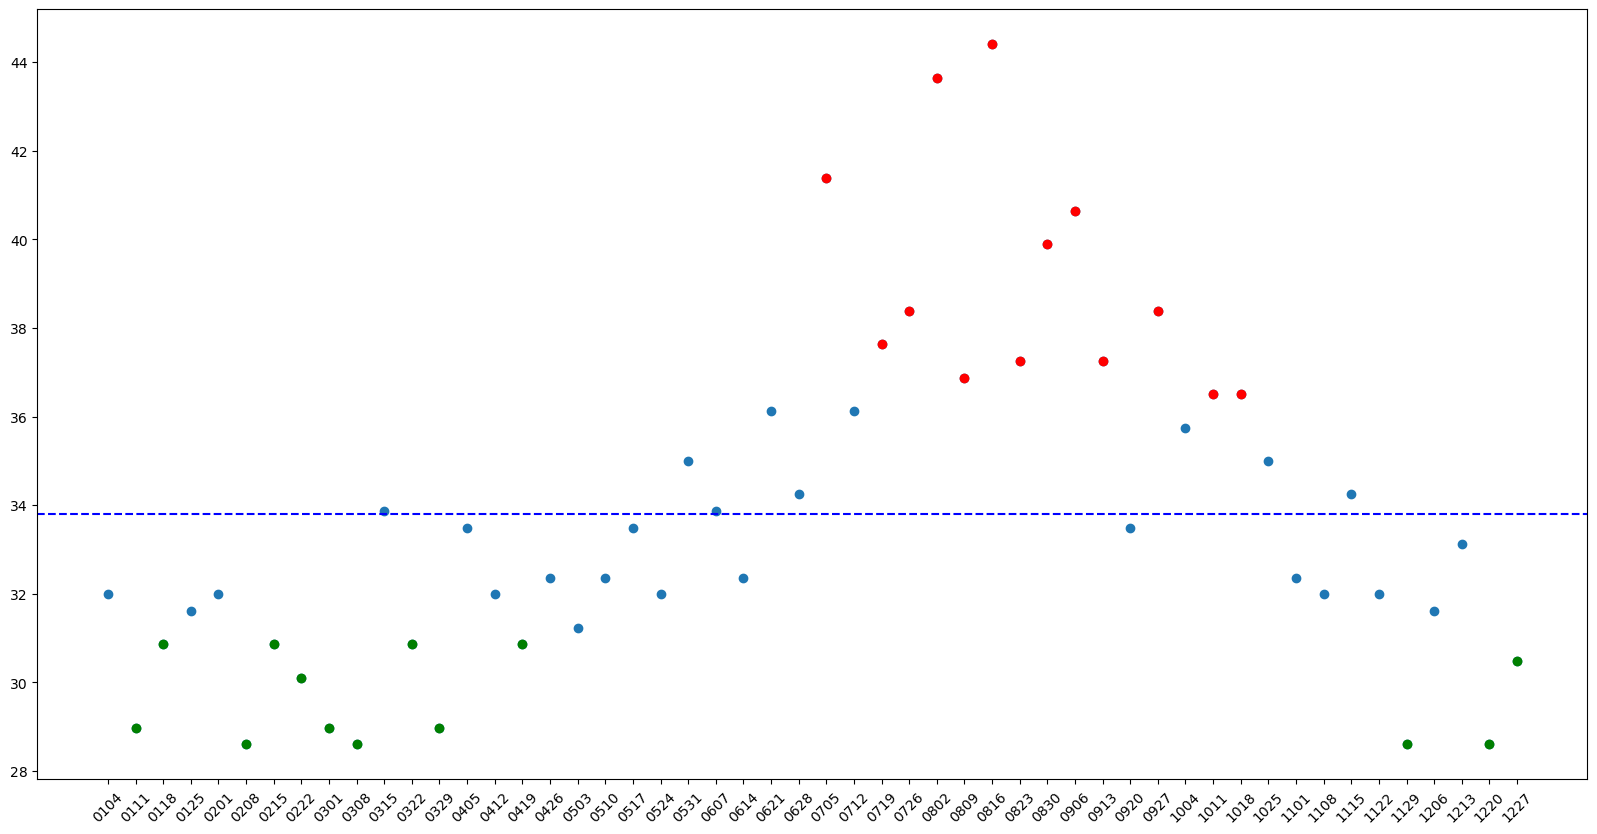

In [217]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_traj_time_2021, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2021,traj_time_2021)
plt.scatter(dates_2021_best,traj_time_best_2021,color='green')
plt.scatter(dates_2021_worst,traj_time_worst_2021,color='red')

## 2018

In [218]:
dates_2018=[date[4:8] for date in dates_str_2018]
dates_2018_best=[date[4:8] for date in list(data_best_2018.keys())]
dates_2018_worst=[date[4:8] for date in list(data_worst_2018.keys())]

In [219]:
avg_windspeed_2018,avg_winddir_2018,avg_windspeed_best_2018,avg_winddir_best_2018,avg_windspeed_worst_2018,avg_winddir_worst_2018=get_avg_wind_cond(windspeed_2018,winddir_2018,windspeed_best_2018,winddir_best_2018,windspeed_worst_2018,winddir_worst_2018)
avg_traj_time_2018,avg_traj_time_2020_best,avg_traj_time_2018_worst=get_avg_traj_time(traj_time_2018,traj_time_best_2018,traj_time_worst_2018)


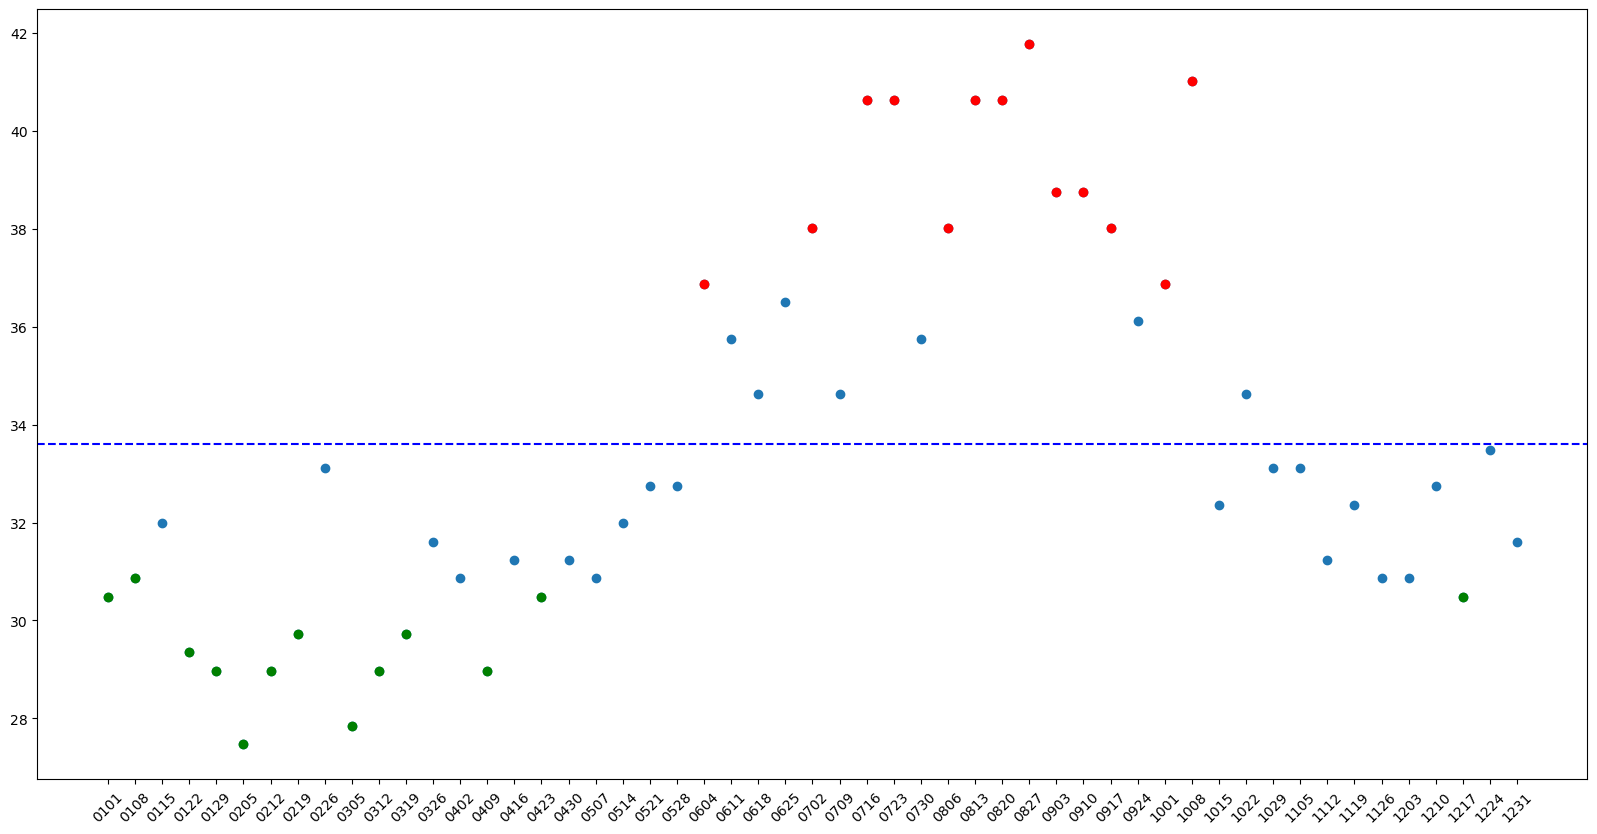

In [220]:
#reflechir a comment afficher les dates ou time_traj>380h
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_traj_time_2018, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2018,traj_time_2018)
plt.scatter(dates_2018_best,traj_time_best_2018,color='green')
plt.scatter(dates_2018_worst,traj_time_worst_2018,color='red')
#plt.scatter(['0321','0328'],[400,400],color='black')

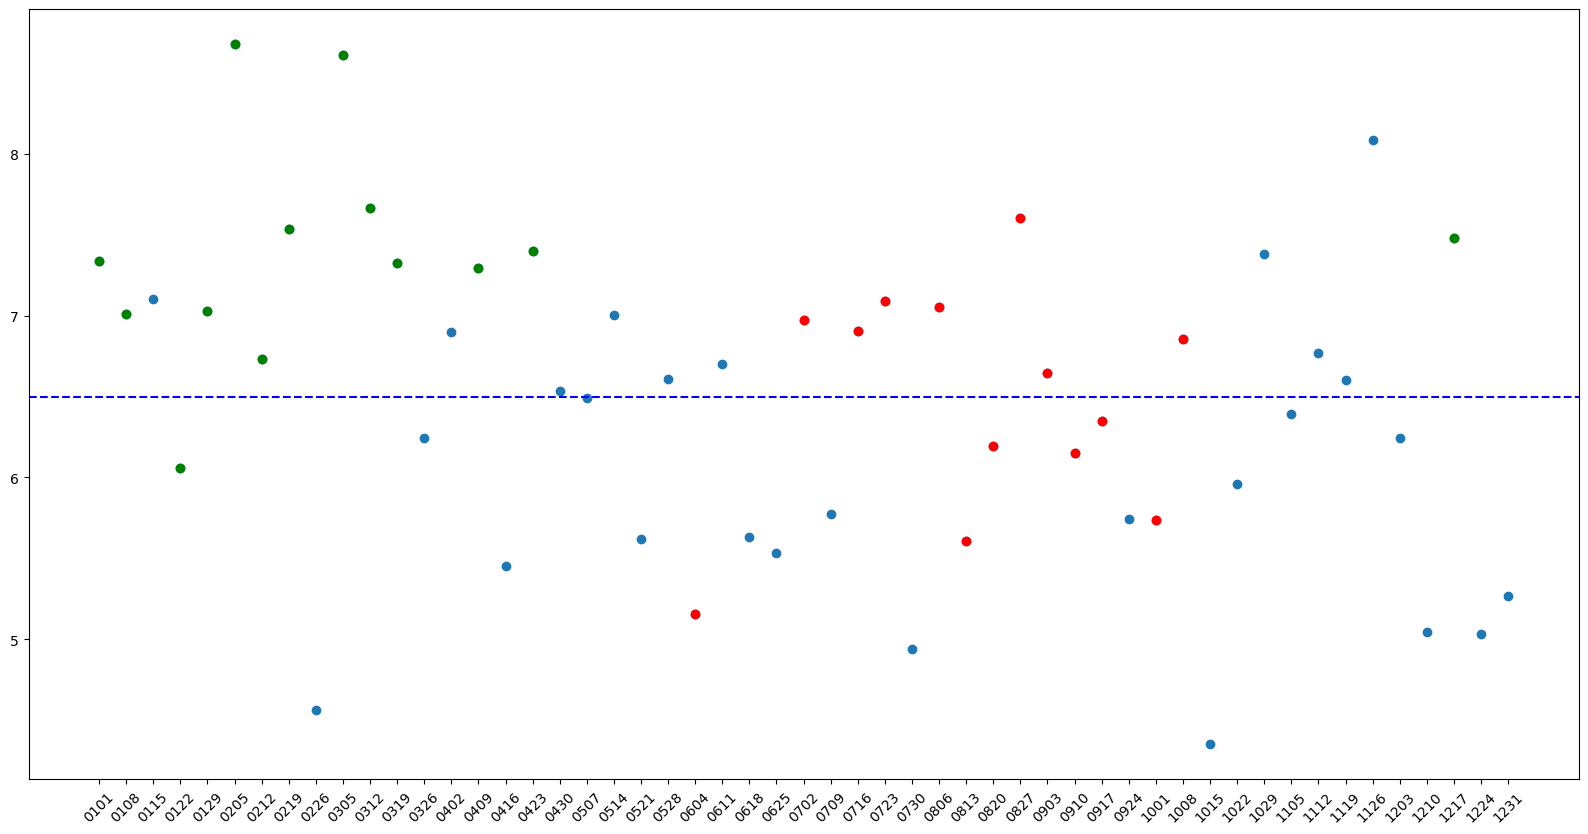

In [221]:
#reflechir a comment afficher les dates ou time_traj>380h
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45) 
plt.axhline(y=avg_windspeed_2018, color='blue', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_best, color='green', linestyle='--')
#plt.axhline(y=avg_traj_time_2022_worst, color='red', linestyle='--')

plt.scatter(dates_2018,windspeed_2018)
plt.scatter(dates_2018_best,windspeed_best_2018,color='green')
plt.scatter(dates_2018_worst,windspeed_worst_2018,color='red')
#plt.scatter(['0321','0328'],[400,400],color='black')

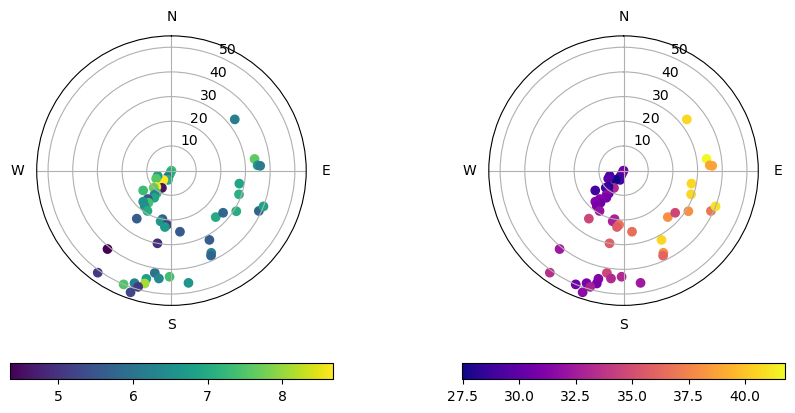

In [222]:
winddir_2018_rad=np.radians(winddir_2018)
#winddir_2022_best_rad=np.radians(winddir_best_2022)
#winddir_2022_worst_rad=np.radians(winddir_worst_2022)

indices=np.arange(len(winddir_2018))
#indices_best = np.where(np.isin(winddir_2022, winddir_best_2022))[0]
#indices_worst = np.where(np.isin(winddir_2022, winddir_worst_2022))[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(polar=True))

for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)
    
c0 = axes[0].scatter(winddir_2018_rad, indices, c=windspeed_2018, cmap='viridis')
axes[0].set_xticks(np.radians([0, 90, 180, 270]))
axes[0].set_xticklabels(['N', 'E', 'S', 'W'])

c1 = axes[1].scatter(winddir_2018_rad, indices, c=traj_time_2018, cmap='plasma')
axes[1].set_xticks(np.radians([0, 90, 180, 270]))
axes[1].set_xticklabels(['N', 'E', 'S', 'W'])

fig.colorbar(c0, ax=axes[0], orientation='horizontal')
fig.colorbar(c1, ax=axes[1], orientation='horizontal')

plt.subplots_adjust(wspace=0.4)
plt.show()